# Cumulative event counter

### This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of apoptosis events

1. Load dictionary of apoptoses and their corresponding times to base the spatiotemporal scans around 
2. Load corresponding tracking data and specify scan parameters
3. Iteratively calculate spatiotemporal distribution of cellular events around apoptoses, saving each distribution out as a .npy distance-time heatmap
4. Compile list of spatiotemporal heatmaps as cumulative heatmap
5. Misc. section: comparing different experimental conditions

In [1]:
import calculate_radial_analysis as calculate
import tools
import render
import dataio

import json
import glob
import os
import re
import numpy as np
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In /home/nathan/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nathan/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nathan/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/nathan/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/nathan/anaconda3/lib/python3.7/site-packages/matplo

## 1) Apoptosis dictionary loader
Specify cell type to filter out unwanted apoptoses, want end result of apop_dict that takes the format of :`apop_dict = {apop_ID:apop_time}` 

where `apop_ID` takes the format of: `GV{experiment_ID}_Pos{position_ID}_{cell_ID}_{cell_type}` 

For example: 

```
apop_dict = {'GV0794_Pos4_393_GFP': '766',
             'GV0794_Pos7_364_GFP': '550',
             'GV0794_Pos7_457_GFP': '805',
             'GV0794_Pos7_369_GFP': '833',
             'GV0794_Pos7_292_GFP': '884',
             'GV0795_Pos4_358_GFP': '628',
             'GV0795_Pos4_18_GFP': '855',
             'GV0795_Pos4_1356_GFP': '992',
             'GV0795_Pos4_359_GFP': '1133',
             'GV0796_Pos4_542_GFP': '581',
             'GV0796_Pos4_1334_GFP': '719',
             'GV0796_Pos4_1586_GFP': '785'}
 ```
 
Function to load apoptosis dictionary from preexisting data store:

`dataio.apoptosis_list_loader(path_to_apop_lists, cell_type)`

Where the `path_to_apop_lists` is the directory containing the apoptosis information and the `cell_type` is either `'Scr'` or `'WT'`.

In [6]:
path_to_apop_lists = '/home/nathan/data/kraken/h2b/giulia/apoptosis_information/final/all'
apop_dict = dataio.apoptosis_list_loader(path_to_apop_lists, 'Scr')
apop_dict

{'GV0797_Pos21_78_RFP': '186',
 'GV0797_Pos21_54_RFP': '238',
 'GV0797_Pos21_55_RFP': '268',
 'GV0797_Pos21_83_RFP': '372',
 'GV0797_Pos21_302_RFP': '380',
 'GV0797_Pos21_22_RFP': '476',
 'GV0797_Pos21_335_RFP': '506',
 'GV0797_Pos21_334_RFP': '607',
 'GV0797_Pos21_35_RFP': '634',
 'GV0816_Pos0_406_RFP': '774',
 'GV0816_Pos0_351_RFP': '873',
 'GV0816_Pos0_374_RFP': '911',
 'GV0816_Pos0_526_RFP': '904',
 'GV0816_Pos0_343_RFP': '943',
 'GV0800_Pos8_9_RFP': '109',
 'GV0800_Pos8_74_RFP': '438',
 'GV0800_Pos8_75_RFP': '546',
 'GV0800_Pos8_118_RFP': '699',
 'GV0800_Pos8_160_RFP': '806',
 'GV0800_Pos8_162_RFP': '806',
 'GV0796_Pos21_13_RFP': '71',
 'GV0796_Pos21_16_RFP': '131',
 'GV0796_Pos21_30_RFP': '136',
 'GV0796_Pos21_23_RFP': '244',
 'GV0796_Pos21_14_RFP': '272',
 'GV0796_Pos21_230_RFP': '343',
 'GV0796_Pos21_314_RFP': '451',
 'GV0796_Pos21_252_RFP': '547',
 'GV0796_Pos21_282_RFP': '642',
 'GV0796_Pos21_18_RFP': '679',
 'GV0796_Pos21_676_RFP': '719',
 'GV0796_Pos21_675_RFP': '720',
 'GV

In [10]:
### optional parallelisation step
N_apops = len(apop_dict)
para_frac_min, para_frac_max = int(0*N_apops), int(1*N_apops)  ## ie only do first 1/4 of all apops
delete_list =[]
for i, j in enumerate(apop_dict):
    if not para_frac_min <= i< para_frac_max: 
        delete_list.append(j)
for i in delete_list:
    del apop_dict[i]
print("Length of modified dict vs original:", len(apop_dict), "/", N_apops)

Length of modified dict vs original: 385 / 385


## 2) Load corresponding cell tracking data and specifiy other parameters

`dataio.hdf5_file_finder(parent_folder_hdf5)` loads a list of all hdf5 files when supplied with the parent directory of all the experiments. This relies on a typical sub-parent directory structure of `'GV****/Pos*/*aligned/HDF/segmented.hdf5'` (aligned folder optional)

In [11]:
### load tracking data
parent_folder_hdf5 = '/home/nathan/data/kraken/h2b/giulia'
hdf5_file_list = dataio.hdf5_file_finder(parent_folder_hdf5)

### specify output path and neighbourhood scan parameters
radius, t_range, num_bins = 400, 400, 10#800, 800, 20#400, 400, 10
output_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/{}.{}.{}/wt_apop_wt_div'.format(radius, t_range, num_bins)
Path(output_path).mkdir(parents=True, exist_ok=True)

## 3) Iteratively calculate and save out individual heatmaps

This step can be time consuming (sequential scans around 385 apoptoses took 7 hours on i7)

Function to calculate:

`calculate.iterative_heatmap_generator(subject_cells = 'WT', subject_event = 'DIVIDE', apop_dict, hdf5_file_list, radius, t_range, num_bins, output_path)`

Where the necessary input variables are as follows:
- `subject_cells` = The population of cells to scan over looking for events, 'WT'/'Scr'/'All'
- `subject_event` = The event type to look for, 'DIVIDE' or 'APOPTOSIS'
- `apop_dict` = Previously defined python dictionary of {apoptosis ID: apoptosis time}
- `hdf5_file_list` = List of locations of tracking files
- `radius` = Distance to scan over around apoptosis
- `t_range` = Time range to scan over around apoptosis (will scan t_range/2 before and after apoptosis)
- `num_bins` = Number of bins the histogram is sorted into
- `output_path` = Empty directory to save out individual apoptosis heatmap .npy arrays into


In [12]:
N_cells, error_log, success_log = calculate.iterative_heatmap_generator(
    'WT', ## 'Scr',
    'DIVIDE', 
    apop_dict, 
    hdf5_file_list, 
    radius, 
    t_range, 
    num_bins, 
    output_path)

  0%|          | 0/385 [00:00<?, ?it/s][INFO][2021/05/10 04:09:24 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 04:09:24 PM] Loading tracks/obj_type_1


ID GV0819_Pos0_677_GFP
Loading GV0819/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/10 04:09:26 PM] Loading objects/obj_type_1 (285723, 5) (262105 filtered: area>=100)
[INFO][2021/05/10 04:09:28 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 04:09:28 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 04:09:28 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 04:09:29 PM] Loading objects/obj_type_2 (79945, 5) (62473 filtered: area>=100)
[INFO][2021/05/10 04:09:30 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos0/


  0%|          | 1/385 [01:01<6:30:33, 61.03s/it]

ID GV0819_Pos0_913_GFP


  1%|          | 2/385 [03:00<10:10:50, 95.69s/it]

ID GV0819_Pos0_898_GFP


  1%|          | 3/385 [04:33<9:59:20, 94.14s/it] 

ID GV0819_Pos0_22_GFP


  1%|          | 4/385 [11:18<22:57:49, 216.98s/it]

ID GV0819_Pos0_1_GFP


  1%|▏         | 5/385 [17:29<28:45:51, 272.50s/it]

ID GV0819_Pos0_1831_GFP


  2%|▏         | 6/385 [19:25<23:04:07, 219.12s/it]

ID GV0819_Pos0_897_GFP


  2%|▏         | 7/385 [23:30<23:53:48, 227.59s/it]

ID GV0819_Pos0_847_GFP


  2%|▏         | 8/385 [26:23<22:01:53, 210.38s/it]

ID GV0819_Pos0_846_GFP


  2%|▏         | 9/385 [28:53<19:59:47, 191.46s/it]

ID GV0819_Pos0_1712_GFP


  3%|▎         | 10/385 [29:55<15:47:43, 151.64s/it]

ID GV0819_Pos0_2151_GFP


  3%|▎         | 11/385 [31:23<13:43:28, 132.11s/it]

ID GV0819_Pos0_673_GFP


  3%|▎         | 12/385 [35:12<16:43:51, 161.48s/it]

ID GV0819_Pos0_1319_GFP


  3%|▎         | 13/385 [38:14<17:19:13, 167.62s/it]

ID GV0819_Pos0_2622_GFP


  4%|▎         | 14/385 [38:48<13:08:00, 127.44s/it]

ID GV0819_Pos0_1622_GFP


  4%|▍         | 15/385 [40:32<12:22:01, 120.33s/it]

ID GV0819_Pos0_98_GFP


  4%|▍         | 16/385 [47:55<22:17:15, 217.44s/it]

ID GV0819_Pos0_2345_GFP


  4%|▍         | 17/385 [48:49<17:12:51, 168.40s/it]

ID GV0819_Pos0_643_GFP


  5%|▍         | 18/385 [51:47<17:26:28, 171.09s/it]

ID GV0819_Pos0_1588_GFP


  5%|▍         | 19/385 [54:51<17:48:09, 175.11s/it]

ID GV0819_Pos0_1587_GFP


  5%|▌         | 20/385 [57:46<17:43:49, 174.88s/it]

ID GV0819_Pos0_843_GFP


  5%|▌         | 21/385 [1:02:14<20:31:08, 202.94s/it]

ID GV0819_Pos0_2269_GFP


  6%|▌         | 22/385 [1:03:23<16:25:03, 162.82s/it]

ID GV0819_Pos0_2268_GFP


  6%|▌         | 23/385 [1:04:34<13:35:10, 135.11s/it]

ID GV0819_Pos0_1371_GFP


  6%|▌         | 24/385 [1:08:13<16:04:32, 160.31s/it]

ID GV0819_Pos0_1370_GFP


  6%|▋         | 25/385 [1:11:29<17:06:34, 171.10s/it]

ID GV0819_Pos0_838_GFP


  7%|▋         | 26/385 [1:16:05<20:12:33, 202.66s/it]

ID GV0819_Pos0_912_GFP


  7%|▋         | 27/385 [1:20:29<21:58:44, 221.02s/it]

ID GV0819_Pos0_1272_GFP


  7%|▋         | 28/385 [1:23:29<20:41:42, 208.69s/it]

ID GV0819_Pos0_144_GFP


  8%|▊         | 29/385 [1:29:34<25:15:46, 255.47s/it]

ID GV0819_Pos0_1210_GFP


  8%|▊         | 30/385 [1:32:40<23:09:21, 234.82s/it]

ID GV0819_Pos0_1211_GFP


  8%|▊         | 31/385 [1:35:03<20:21:56, 207.11s/it]

ID GV0819_Pos0_3087_GFP


  8%|▊         | 32/385 [1:35:45<15:26:44, 157.52s/it]

ID GV0819_Pos0_3037_GFP


  9%|▊         | 33/385 [1:36:13<11:36:28, 118.72s/it]

ID GV0819_Pos0_1740_GFP


  9%|▉         | 34/385 [1:38:40<12:24:25, 127.25s/it]

ID GV0819_Pos0_1742_GFP


  9%|▉         | 35/385 [1:41:16<13:12:31, 135.86s/it]

ID GV0819_Pos0_829_GFP


  9%|▉         | 36/385 [1:45:42<16:58:03, 175.03s/it]

ID GV0819_Pos0_1074_GFP


 10%|▉         | 37/385 [1:49:43<18:49:46, 194.79s/it]

ID GV0819_Pos0_2369_GFP


 10%|▉         | 38/385 [1:51:34<16:20:24, 169.52s/it]

ID GV0819_Pos0_2308_GFP


 10%|█         | 39/385 [1:53:26<14:39:06, 152.45s/it]

ID GV0819_Pos0_3216_GFP


 10%|█         | 40/385 [1:53:58<11:08:26, 116.25s/it]

ID GV0819_Pos0_2206_GFP


 11%|█         | 41/385 [1:56:16<11:44:19, 122.85s/it]

ID GV0819_Pos0_2018_GFP


 11%|█         | 42/385 [1:58:17<11:38:56, 122.26s/it]

ID GV0819_Pos0_2009_GFP


 11%|█         | 43/385 [2:00:29<11:52:29, 125.00s/it]

ID GV0819_Pos0_412_GFP


 11%|█▏        | 44/385 [2:05:58<17:38:28, 186.24s/it]

ID GV0819_Pos0_1737_GFP


 12%|█▏        | 45/385 [2:08:45<17:02:41, 180.47s/it]

ID GV0819_Pos0_2886_GFP


 12%|█▏        | 46/385 [2:09:44<13:33:51, 144.04s/it][INFO][2021/05/10 06:19:09 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 06:19:09 PM] Loading tracks/obj_type_1


ID GV0814_Pos12_354_GFP
Loading GV0814/Pos12/
Btrack version no.: 0.4.0


[INFO][2021/05/10 06:19:11 PM] Loading objects/obj_type_1 (387469, 5) (361100 filtered: area>=100)
[INFO][2021/05/10 06:19:15 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 06:19:15 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 06:19:15 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 06:19:16 PM] Loading objects/obj_type_2 (48265, 5) (39349 filtered: area>=100)
[INFO][2021/05/10 06:19:17 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0814/Pos12/


 12%|█▏        | 47/385 [2:13:24<15:40:26, 166.94s/it]

ID GV0814_Pos12_3629_GFP


 12%|█▏        | 48/385 [2:14:49<13:19:04, 142.27s/it][INFO][2021/05/10 06:24:14 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 06:24:14 PM] Loading tracks/obj_type_1


ID GV0795_Pos4_358_GFP
Loading GV0795/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 06:24:16 PM] Loading objects/obj_type_1 (211479, 5) (197642 filtered: area>=100)
[INFO][2021/05/10 06:24:18 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 06:24:18 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 06:24:18 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 06:24:19 PM] Loading objects/obj_type_2 (49070, 5) (38203 filtered: area>=100)
[INFO][2021/05/10 06:24:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos4/


 13%|█▎        | 49/385 [2:17:12<13:18:42, 142.63s/it]

ID GV0795_Pos4_18_GFP


 13%|█▎        | 50/385 [2:21:45<16:53:29, 181.52s/it]

ID GV0795_Pos4_1356_GFP


 13%|█▎        | 51/385 [2:22:26<12:56:14, 139.44s/it]

ID GV0795_Pos4_359_GFP


 14%|█▎        | 52/385 [2:25:44<14:31:04, 156.95s/it][INFO][2021/05/10 06:35:09 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 06:35:09 PM] Loading tracks/obj_type_1


ID GV0817_Pos0_7_GFP
Loading GV0817/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/10 06:35:11 PM] Loading objects/obj_type_1 (279987, 5) (256086 filtered: area>=100)
[INFO][2021/05/10 06:35:15 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 06:35:15 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 06:35:15 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 06:35:16 PM] Loading objects/obj_type_2 (113873, 5) (83931 filtered: area>=100)
[INFO][2021/05/10 06:35:17 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos0/


 14%|█▍        | 53/385 [2:30:54<18:42:30, 202.86s/it]

ID GV0817_Pos0_901_GFP


 14%|█▍        | 54/385 [2:32:35<15:50:34, 172.31s/it]

ID GV0817_Pos0_1108_GFP


 14%|█▍        | 55/385 [2:34:06<13:33:33, 147.92s/it]

ID GV0817_Pos0_1541_GFP


 15%|█▍        | 56/385 [2:36:59<14:12:40, 155.50s/it]

ID GV0817_Pos0_2082_GFP


 15%|█▍        | 57/385 [2:37:49<11:17:04, 123.86s/it]

ID GV0817_Pos0_737_GFP


 15%|█▌        | 58/385 [2:40:51<12:49:50, 141.25s/it]

ID GV0817_Pos0_1731_GFP


 15%|█▌        | 59/385 [2:42:27<11:34:21, 127.80s/it]

ID GV0817_Pos0_1542_GFP


 16%|█▌        | 60/385 [2:44:23<11:12:13, 124.10s/it]

ID GV0817_Pos0_687_GFP


 16%|█▌        | 61/385 [2:48:27<14:24:17, 160.05s/it]

ID GV0817_Pos0_1440_GFP


 16%|█▌        | 62/385 [2:51:25<14:51:31, 165.61s/it]

ID GV0817_Pos0_1928_GFP


 16%|█▋        | 63/385 [2:53:06<13:05:01, 146.28s/it]

ID GV0817_Pos0_224_GFP


 17%|█▋        | 64/385 [2:57:33<16:15:52, 182.41s/it]

ID GV0817_Pos0_2109_GFP


 17%|█▋        | 65/385 [2:59:42<14:47:31, 166.41s/it]

ID GV0817_Pos0_2855_GFP


 17%|█▋        | 66/385 [3:00:50<12:08:14, 136.97s/it]

ID GV0817_Pos0_2188_GFP


 17%|█▋        | 67/385 [3:03:12<12:13:16, 138.35s/it]

ID GV0817_Pos0_2181_GFP


 18%|█▊        | 68/385 [3:05:31<12:11:32, 138.46s/it][INFO][2021/05/10 07:14:56 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:14:56 PM] Loading tracks/obj_type_1


ID GV0813_Pos1_886_GFP
Loading GV0813/Pos1/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:14:57 PM] Loading objects/obj_type_1 (149696, 5) (120384 filtered: area>=100)
[INFO][2021/05/10 07:14:59 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:14:59 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:14:59 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:14:59 PM] Loading objects/obj_type_2 (30851, 5) (22174 filtered: area>=100)
[INFO][2021/05/10 07:14:59 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos1/


 18%|█▊        | 69/385 [3:06:04<9:23:42, 107.03s/it] [INFO][2021/05/10 07:15:29 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:15:29 PM] Loading tracks/obj_type_1


ID GV0819_Pos3_586_GFP
Loading GV0819/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:15:33 PM] Loading objects/obj_type_1 (444670, 5) (426511 filtered: area>=100)
[INFO][2021/05/10 07:15:39 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:15:39 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:15:39 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:15:40 PM] Loading objects/obj_type_2 (119062, 5) (102355 filtered: area>=100)
[INFO][2021/05/10 07:15:42 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos3/


 18%|█▊        | 70/385 [3:08:26<10:16:37, 117.45s/it]

ID GV0819_Pos3_741_GFP


 18%|█▊        | 71/385 [3:12:52<14:07:48, 162.00s/it][INFO][2021/05/10 07:22:17 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:22:17 PM] Loading tracks/obj_type_1


ID GV0819_Pos4_1586_GFP
Loading GV0819/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:22:20 PM] Loading objects/obj_type_1 (393596, 5) (379449 filtered: area>=100)
[INFO][2021/05/10 07:22:26 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:22:26 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:22:26 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:22:27 PM] Loading objects/obj_type_2 (112602, 5) (100064 filtered: area>=100)
[INFO][2021/05/10 07:22:29 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos4/


 19%|█▊        | 72/385 [3:14:20<12:08:59, 139.74s/it]

ID GV0819_Pos4_2425_GFP


 19%|█▉        | 73/385 [3:16:38<12:04:33, 139.34s/it]

ID GV0819_Pos4_2609_GFP


 19%|█▉        | 74/385 [3:18:10<10:48:01, 125.02s/it][INFO][2021/05/10 07:27:35 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:27:35 PM] Loading tracks/obj_type_1


ID GV0800_Pos6_361_GFP
Loading GV0800/Pos6/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:27:35 PM] Loading objects/obj_type_1 (52406, 5) (44528 filtered: area>=100)
[INFO][2021/05/10 07:27:36 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:27:36 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:27:36 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:27:37 PM] Loading objects/obj_type_2 (113641, 5) (87932 filtered: area>=100)
[INFO][2021/05/10 07:27:38 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos6/


 19%|█▉        | 75/385 [3:18:26<7:56:34, 92.24s/it]  

ID GV0800_Pos6_302_GFP


 20%|█▉        | 76/385 [3:18:54<6:16:32, 73.11s/it][INFO][2021/05/10 07:28:19 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:28:19 PM] Loading tracks/obj_type_1


ID GV0797_Pos8_1104_GFP
Loading GV0797/Pos8/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:28:21 PM] Loading objects/obj_type_1 (294496, 5) (285144 filtered: area>=100)
[INFO][2021/05/10 07:28:26 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:28:26 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:28:26 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:28:26 PM] Loading objects/obj_type_2 (6854, 5) (5414 filtered: area>=100)
[INFO][2021/05/10 07:28:26 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos8/


 20%|██        | 77/385 [3:20:30<6:50:10, 79.90s/it][INFO][2021/05/10 07:29:55 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:29:55 PM] Loading tracks/obj_type_1


ID GV0806_Pos3_571_GFP
Loading GV0806/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:30:01 PM] Loading objects/obj_type_1 (704893, 5) (675206 filtered: area>=100)
[INFO][2021/05/10 07:30:12 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:30:12 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:30:12 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:30:12 PM] Loading objects/obj_type_2 (18126, 5) (15960 filtered: area>=100)
[INFO][2021/05/10 07:30:12 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0806/Pos3/


 20%|██        | 78/385 [3:23:45<9:45:32, 114.44s/it][INFO][2021/05/10 07:33:10 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:33:10 PM] Loading tracks/obj_type_1


ID GV0796_Pos7_44_GFP
Loading GV0796/Pos7/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:33:13 PM] Loading objects/obj_type_1 (510473, 5) (495699 filtered: area>=100)
[INFO][2021/05/10 07:33:18 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:33:18 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:33:18 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:33:18 PM] Loading objects/obj_type_2 (76238, 5) (63068 filtered: area>=100)
[INFO][2021/05/10 07:33:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos7/


 21%|██        | 79/385 [3:29:14<15:11:41, 178.76s/it]

ID GV0796_Pos7_541_GFP


 21%|██        | 80/385 [3:34:38<18:50:09, 222.32s/it]

ID GV0796_Pos7_803_GFP


 21%|██        | 81/385 [3:37:46<17:54:58, 212.17s/it][INFO][2021/05/10 07:47:11 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:47:11 PM] Loading tracks/obj_type_1


ID GV0796_Pos19_77_GFP
Loading GV0796/Pos19/
Btrack version no.: 0.4.0


[INFO][2021/05/10 07:47:14 PM] Loading objects/obj_type_1 (506574, 5) (490755 filtered: area>=100)
[INFO][2021/05/10 07:47:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 07:47:19 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 07:47:19 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 07:47:19 PM] Loading objects/obj_type_2 (13897, 5) (11779 filtered: area>=100)
[INFO][2021/05/10 07:47:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos19/Pos19_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos19/


 21%|██▏       | 82/385 [3:43:19<20:53:27, 248.21s/it]

ID GV0796_Pos19_441_GFP


 22%|██▏       | 83/385 [3:45:55<18:30:34, 220.64s/it]

ID GV0796_Pos19_431_GFP


 22%|██▏       | 84/385 [3:49:33<18:22:29, 219.77s/it]

ID GV0796_Pos19_2161_GFP


 22%|██▏       | 85/385 [3:52:00<16:30:30, 198.10s/it]

ID GV0796_Pos19_1960_GFP


 22%|██▏       | 86/385 [3:55:49<17:13:48, 207.45s/it][INFO][2021/05/10 08:05:14 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:05:14 PM] Loading tracks/obj_type_1


ID GV0797_Pos7_724_GFP
Loading GV0797/Pos7/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:05:15 PM] Loading objects/obj_type_1 (207794, 5) (196573 filtered: area>=100)
[INFO][2021/05/10 08:05:18 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:05:18 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:05:18 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:05:18 PM] Loading objects/obj_type_2 (22939, 5) (18826 filtered: area>=100)
[INFO][2021/05/10 08:05:18 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos7/


 23%|██▎       | 87/385 [3:56:18<12:43:11, 153.66s/it]

ID GV0797_Pos7_192_GFP


 23%|██▎       | 88/385 [3:57:53<11:14:33, 136.27s/it]

ID GV0797_Pos7_230_GFP


 23%|██▎       | 89/385 [4:00:54<12:18:13, 149.64s/it]

ID GV0797_Pos7_1103_GFP


 23%|██▎       | 90/385 [4:01:20<9:13:05, 112.49s/it] 

ID GV0797_Pos7_1029_GFP


 24%|██▎       | 91/385 [4:02:49<8:36:34, 105.42s/it][INFO][2021/05/10 08:12:14 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:12:14 PM] Loading tracks/obj_type_1


ID GV0796_Pos21_2923_GFP
Loading GV0796/Pos21/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:12:16 PM] Loading objects/obj_type_1 (307793, 5) (293005 filtered: area>=100)
[INFO][2021/05/10 08:12:21 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:12:21 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:12:21 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:12:22 PM] Loading objects/obj_type_2 (46439, 5) (38835 filtered: area>=100)
[INFO][2021/05/10 08:12:23 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos21/


 24%|██▍       | 92/385 [4:03:23<6:50:23, 84.04s/it] 

ID GV0796_Pos21_788_GFP


 24%|██▍       | 93/385 [4:05:52<8:23:07, 103.38s/it][INFO][2021/05/10 08:15:16 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:15:16 PM] Loading tracks/obj_type_1


ID GV0816_Pos23_5_GFP
Loading GV0816/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:15:17 PM] Loading objects/obj_type_1 (108996, 5) (100437 filtered: area>=100)
[INFO][2021/05/10 08:15:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:15:19 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:15:19 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:15:19 PM] Loading objects/obj_type_2 (36035, 5) (29738 filtered: area>=100)
[INFO][2021/05/10 08:15:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos23/


 24%|██▍       | 94/385 [4:06:22<6:35:22, 81.52s/it] 

ID GV0816_Pos23_1_GFP


 25%|██▍       | 95/385 [4:07:36<6:22:52, 79.22s/it]

ID GV0816_Pos23_755_GFP


 25%|██▍       | 96/385 [4:08:05<5:08:27, 64.04s/it]

ID GV0816_Pos23_757_GFP


 25%|██▌       | 97/385 [4:08:16<3:51:02, 48.13s/it]

ID GV0816_Pos23_773_GFP


 25%|██▌       | 98/385 [4:08:48<3:28:17, 43.55s/it]

ID GV0816_Pos23_772_GFP


 26%|██▌       | 99/385 [4:09:22<3:13:59, 40.70s/it]

ID GV0816_Pos23_696_GFP


 26%|██▌       | 100/385 [4:09:41<2:41:59, 34.10s/it][INFO][2021/05/10 08:19:06 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:19:06 PM] Loading tracks/obj_type_1


ID GV0800_Pos17_7_GFP
Loading GV0800/Pos17/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:19:07 PM] Loading objects/obj_type_1 (102414, 5) (89276 filtered: area>=100)
[INFO][2021/05/10 08:19:07 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:19:07 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:19:07 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:19:08 PM] Loading objects/obj_type_2 (83250, 5) (67284 filtered: area>=100)
[INFO][2021/05/10 08:19:09 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos17/Pos17_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos17/


 26%|██▌       | 101/385 [4:10:24<2:54:02, 36.77s/it]

ID GV0800_Pos17_1010_GFP


 26%|██▋       | 102/385 [4:11:00<2:52:00, 36.47s/it]

ID GV0800_Pos17_1009_GFP


 27%|██▋       | 103/385 [4:11:41<2:58:02, 37.88s/it]

ID GV0800_Pos17_868_GFP


 27%|██▋       | 104/385 [4:12:23<3:03:42, 39.23s/it]

ID GV0800_Pos17_869_GFP


 27%|██▋       | 105/385 [4:13:06<3:07:50, 40.25s/it]

ID GV0800_Pos17_1001_GFP


 28%|██▊       | 106/385 [4:14:03<3:30:39, 45.30s/it]

ID GV0800_Pos17_1002_GFP


 28%|██▊       | 107/385 [4:15:00<3:46:22, 48.86s/it][INFO][2021/05/10 08:24:25 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:24:25 PM] Loading tracks/obj_type_1


ID GV0806_Pos5_124_GFP
Loading GV0806/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:24:26 PM] Loading objects/obj_type_1 (76725, 5) (65455 filtered: area>=100)
[INFO][2021/05/10 08:24:27 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:24:27 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:24:27 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:24:28 PM] Loading objects/obj_type_2 (76899, 5) (56104 filtered: area>=100)
[INFO][2021/05/10 08:24:28 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0806/Pos5/


 28%|██▊       | 108/385 [4:16:40<4:56:09, 64.15s/it][INFO][2021/05/10 08:26:05 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:26:05 PM] Loading tracks/obj_type_1


ID GV0800_Pos4_480_GFP
Loading GV0800/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:26:07 PM] Loading objects/obj_type_1 (293631, 5) (274724 filtered: area>=100)
[INFO][2021/05/10 08:26:12 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:26:12 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:26:12 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:26:12 PM] Loading objects/obj_type_2 (60789, 5) (49434 filtered: area>=100)
[INFO][2021/05/10 08:26:13 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos4/


 28%|██▊       | 109/385 [4:18:30<5:58:07, 77.85s/it][INFO][2021/05/10 08:27:55 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:27:55 PM] Loading tracks/obj_type_1


ID GV0820_Pos5_47_GFP
Loading GV0820/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:27:56 PM] Loading objects/obj_type_1 (168718, 5) (157112 filtered: area>=100)
[INFO][2021/05/10 08:27:59 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:27:59 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:27:59 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:28:00 PM] Loading objects/obj_type_2 (75424, 5) (61898 filtered: area>=100)
[INFO][2021/05/10 08:28:01 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos5/


 29%|██▊       | 110/385 [4:20:28<6:52:23, 89.98s/it]

ID GV0820_Pos5_48_GFP


 29%|██▉       | 111/385 [4:22:42<7:50:33, 103.04s/it]

ID GV0820_Pos5_417_GFP


 29%|██▉       | 112/385 [4:24:45<8:15:55, 108.99s/it]

ID GV0820_Pos5_1837_GFP


 29%|██▉       | 113/385 [4:25:08<6:17:33, 83.29s/it] [INFO][2021/05/10 08:34:33 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:34:33 PM] Loading tracks/obj_type_1


ID GV0813_Pos0_137_GFP
Loading GV0813/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:34:34 PM] Loading objects/obj_type_1 (85389, 5) (80063 filtered: area>=100)
[INFO][2021/05/10 08:34:35 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:34:35 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:34:35 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:34:35 PM] Loading objects/obj_type_2 (20301, 5) (17076 filtered: area>=100)
[INFO][2021/05/10 08:34:35 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos0/


 30%|██▉       | 114/385 [4:25:50<5:20:29, 70.96s/it]

ID GV0813_Pos0_356_GFP


 30%|██▉       | 115/385 [4:26:36<4:45:46, 63.50s/it]

ID GV0813_Pos0_260_GFP


 30%|███       | 116/385 [4:27:08<4:01:58, 53.97s/it]

ID GV0813_Pos0_111_GFP


 30%|███       | 117/385 [4:27:50<3:44:23, 50.24s/it]

ID GV0813_Pos0_223_GFP


 31%|███       | 118/385 [4:28:23<3:21:07, 45.20s/it]

ID GV0813_Pos0_636_GFP


 31%|███       | 119/385 [4:28:30<2:29:01, 33.61s/it][INFO][2021/05/10 08:37:54 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:37:54 PM] Loading tracks/obj_type_1


ID GV0813_Pos4_404_GFP
Loading GV0813/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:37:55 PM] Loading objects/obj_type_1 (150938, 5) (131031 filtered: area>=100)
[INFO][2021/05/10 08:37:56 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:37:56 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:37:56 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:37:57 PM] Loading objects/obj_type_2 (39270, 5) (29540 filtered: area>=100)
[INFO][2021/05/10 08:37:57 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos4/


 31%|███       | 120/385 [4:29:50<3:30:25, 47.64s/it]

ID GV0813_Pos4_596_GFP


 31%|███▏      | 121/385 [4:30:03<2:44:33, 37.40s/it]

ID GV0813_Pos4_403_GFP


 32%|███▏      | 122/385 [4:30:43<2:46:25, 37.97s/it]

ID GV0813_Pos4_7_GFP


 32%|███▏      | 123/385 [4:32:41<4:30:22, 61.92s/it]

ID GV0813_Pos4_1000_GFP


 32%|███▏      | 124/385 [4:32:58<3:30:43, 48.44s/it][INFO][2021/05/10 08:42:22 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:42:22 PM] Loading tracks/obj_type_1


ID GV0819_Pos2_119_GFP
Loading GV0819/Pos2/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:42:24 PM] Loading objects/obj_type_1 (267623, 5) (252570 filtered: area>=100)
[INFO][2021/05/10 08:42:26 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:42:26 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:42:26 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:42:27 PM] Loading objects/obj_type_2 (113484, 5) (97628 filtered: area>=100)
[INFO][2021/05/10 08:42:27 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos2/Pos2_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos2/


 32%|███▏      | 125/385 [4:34:09<4:00:25, 55.48s/it]

ID GV0819_Pos2_481_GFP


 33%|███▎      | 126/385 [4:34:36<3:22:16, 46.86s/it]

ID GV0819_Pos2_513_GFP


 33%|███▎      | 127/385 [4:35:53<4:00:16, 55.88s/it]

ID GV0819_Pos2_143_GFP


 33%|███▎      | 128/385 [4:38:28<6:06:38, 85.60s/it]

ID GV0819_Pos2_1617_GFP


 34%|███▎      | 129/385 [4:39:16<5:17:14, 74.35s/it][INFO][2021/05/10 08:48:41 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:48:41 PM] Loading tracks/obj_type_1


ID GV0820_Pos4_684_GFP
Loading GV0820/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:48:42 PM] Loading objects/obj_type_1 (189653, 5) (175798 filtered: area>=100)
[INFO][2021/05/10 08:48:44 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:48:44 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:48:44 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:48:44 PM] Loading objects/obj_type_2 (82474, 5) (72948 filtered: area>=100)
[INFO][2021/05/10 08:48:45 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos4/


 34%|███▍      | 130/385 [4:41:25<6:26:00, 90.83s/it]

ID GV0820_Pos4_1034_GFP


 34%|███▍      | 131/385 [4:42:36<5:58:23, 84.66s/it]

ID GV0820_Pos4_1634_GFP


 34%|███▍      | 132/385 [4:43:05<4:46:29, 67.94s/it][INFO][2021/05/10 08:52:29 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:52:29 PM] Loading tracks/obj_type_1


ID GV0800_Pos8_263_GFP
Loading GV0800/Pos8/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:52:32 PM] Loading objects/obj_type_1 (412266, 5) (393638 filtered: area>=100)
[INFO][2021/05/10 08:52:35 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:52:35 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:52:35 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:52:35 PM] Loading objects/obj_type_2 (16111, 5) (12664 filtered: area>=100)
[INFO][2021/05/10 08:52:36 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos8/


 35%|███▍      | 133/385 [4:45:19<6:08:42, 87.79s/it]

ID GV0800_Pos8_49_GFP


 35%|███▍      | 134/385 [4:49:13<9:11:22, 131.80s/it][INFO][2021/05/10 08:58:38 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:58:38 PM] Loading tracks/obj_type_1


ID GV0813_Pos3_362_GFP
Loading GV0813/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/10 08:58:39 PM] Loading objects/obj_type_1 (153611, 5) (136100 filtered: area>=100)
[INFO][2021/05/10 08:58:40 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 08:58:40 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 08:58:40 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 08:58:40 PM] Loading objects/obj_type_2 (28558, 5) (22223 filtered: area>=100)
[INFO][2021/05/10 08:58:40 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos3/


 35%|███▌      | 135/385 [4:49:45<7:03:36, 101.67s/it]

ID GV0813_Pos3_15_GFP


 35%|███▌      | 136/385 [4:51:08<6:39:34, 96.28s/it] 

ID GV0813_Pos3_33_GFP


 36%|███▌      | 137/385 [4:52:01<5:44:13, 83.28s/it]

ID GV0813_Pos3_341_GFP


 36%|███▌      | 138/385 [4:52:39<4:46:50, 69.68s/it]

ID GV0813_Pos3_513_GFP


 36%|███▌      | 139/385 [4:53:50<4:46:59, 70.00s/it]

ID GV0813_Pos3_514_GFP


 36%|███▋      | 140/385 [4:54:36<4:15:57, 62.68s/it]

ID GV0813_Pos3_599_GFP


 37%|███▋      | 141/385 [4:55:32<4:06:56, 60.73s/it]

ID GV0813_Pos3_304_GFP


 37%|███▋      | 142/385 [4:57:19<5:02:16, 74.64s/it]

ID GV0813_Pos3_535_GFP


 37%|███▋      | 143/385 [4:58:22<4:46:37, 71.06s/it]

ID GV0813_Pos3_813_GFP


 37%|███▋      | 144/385 [4:59:08<4:15:49, 63.69s/it]

ID GV0813_Pos3_1298_GFP


 38%|███▊      | 145/385 [4:59:44<3:41:11, 55.30s/it]

ID GV0813_Pos3_538_GFP


 38%|███▊      | 146/385 [5:01:04<4:10:15, 62.83s/it]

ID GV0813_Pos3_122_GFP


 38%|███▊      | 147/385 [5:03:18<5:33:50, 84.16s/it][INFO][2021/05/10 09:12:43 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:12:43 PM] Loading tracks/obj_type_1


ID GV0798_Pos23_72_GFP
Loading GV0798/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:12:44 PM] Loading objects/obj_type_1 (122661, 5) (114306 filtered: area>=100)
[INFO][2021/05/10 09:12:45 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:12:45 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:12:45 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:12:45 PM] Loading objects/obj_type_2 (120909, 5) (98424 filtered: area>=100)
[INFO][2021/05/10 09:12:46 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos23/


 38%|███▊      | 148/385 [5:04:19<5:04:57, 77.20s/it]

ID GV0798_Pos23_261_GFP


 39%|███▊      | 149/385 [5:05:26<4:51:38, 74.15s/it]

ID GV0798_Pos23_976_GFP


 39%|███▉      | 150/385 [5:05:52<3:54:00, 59.75s/it]

ID GV0798_Pos23_536_GFP


 39%|███▉      | 151/385 [5:06:31<3:28:36, 53.49s/it][INFO][2021/05/10 09:15:56 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:15:56 PM] Loading tracks/obj_type_1


ID GV0807_Pos5_1493_GFP
Loading GV0807/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:15:57 PM] Loading objects/obj_type_1 (129954, 5) (111411 filtered: area>=100)
[INFO][2021/05/10 09:15:57 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:15:57 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:15:57 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:15:58 PM] Loading objects/obj_type_2 (87213, 5) (74295 filtered: area>=100)
[INFO][2021/05/10 09:15:59 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0807/Pos5/


 39%|███▉      | 152/385 [5:06:49<2:45:52, 42.71s/it][INFO][2021/05/10 09:16:13 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:16:13 PM] Loading tracks/obj_type_1


ID GV0820_Pos3_1521_GFP
Loading GV0820/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:16:14 PM] Loading objects/obj_type_1 (191590, 5) (179288 filtered: area>=100)
[INFO][2021/05/10 09:16:16 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:16:16 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:16:16 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:16:16 PM] Loading objects/obj_type_2 (65619, 5) (55005 filtered: area>=100)
[INFO][2021/05/10 09:16:17 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos3/


 40%|███▉      | 153/385 [5:07:31<2:44:19, 42.50s/it]

ID GV0820_Pos3_605_GFP


 40%|████      | 154/385 [5:09:02<3:40:14, 57.21s/it]

ID GV0820_Pos3_1364_GFP


 40%|████      | 155/385 [5:10:03<3:43:00, 58.17s/it]

ID GV0820_Pos3_2143_GFP


 41%|████      | 156/385 [5:10:16<2:50:14, 44.61s/it]

ID GV0820_Pos3_2006_GFP


 41%|████      | 157/385 [5:10:40<2:26:11, 38.47s/it]

ID GV0820_Pos3_2146_GFP


 41%|████      | 158/385 [5:10:52<1:56:00, 30.66s/it]

ID GV0820_Pos3_1639_GFP


 41%|████▏     | 159/385 [5:11:39<2:13:17, 35.39s/it][INFO][2021/05/10 09:21:03 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:21:03 PM] Loading tracks/obj_type_1


ID GV0796_Pos20_28_GFP
Loading GV0796/Pos20/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:21:06 PM] Loading objects/obj_type_1 (469347, 5) (453478 filtered: area>=100)
[INFO][2021/05/10 09:21:10 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:21:10 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:21:10 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:21:10 PM] Loading objects/obj_type_2 (18513, 5) (14856 filtered: area>=100)
[INFO][2021/05/10 09:21:10 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos20/Pos20_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos20/


 42%|████▏     | 160/385 [5:13:33<3:42:04, 59.22s/it][INFO][2021/05/10 09:22:58 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:22:58 PM] Loading tracks/obj_type_1


ID GV0805_Pos3_682_GFP
Loading GV0805/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:23:01 PM] Loading objects/obj_type_1 (518517, 5) (489660 filtered: area>=100)
[INFO][2021/05/10 09:23:06 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:23:06 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:23:06 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:23:06 PM] Loading objects/obj_type_2 (16677, 5) (12311 filtered: area>=100)
[INFO][2021/05/10 09:23:06 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0805/Pos3/


 42%|████▏     | 161/385 [5:14:54<4:05:10, 65.67s/it]

ID GV0805_Pos3_50_GFP


 42%|████▏     | 162/385 [5:20:09<8:41:56, 140.43s/it]

ID GV0805_Pos3_4_GFP


 42%|████▏     | 163/385 [5:25:25<11:54:54, 193.22s/it][INFO][2021/05/10 09:34:50 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:34:50 PM] Loading tracks/obj_type_1


ID GV0806_Pos4_165_GFP
Loading GV0806/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:34:53 PM] Loading objects/obj_type_1 (509105, 5) (489414 filtered: area>=100)
[INFO][2021/05/10 09:34:57 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:34:57 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:34:57 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:34:58 PM] Loading objects/obj_type_2 (68404, 5) (59567 filtered: area>=100)
[INFO][2021/05/10 09:34:58 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0806/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0806/Pos4/


 43%|████▎     | 164/385 [5:27:31<10:36:52, 172.91s/it]

ID GV0806_Pos4_1452_GFP


 43%|████▎     | 165/385 [5:28:39<8:38:38, 141.45s/it] 

ID GV0806_Pos4_1471_GFP


 43%|████▎     | 166/385 [5:29:20<6:46:51, 111.47s/it]

ID GV0806_Pos4_944_GFP


 43%|████▎     | 167/385 [5:30:57<6:29:13, 107.13s/it]

ID GV0806_Pos4_1258_GFP


 44%|████▎     | 168/385 [5:34:19<8:10:20, 135.58s/it][INFO][2021/05/10 09:43:44 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:43:44 PM] Loading tracks/obj_type_1


ID GV0796_Pos3_1599_GFP
Loading GV0796/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:43:48 PM] Loading objects/obj_type_1 (683581, 5) (648688 filtered: area>=100)
[INFO][2021/05/10 09:43:54 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:43:54 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:43:54 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:43:54 PM] Loading objects/obj_type_2 (16040, 5) (13600 filtered: area>=100)
[INFO][2021/05/10 09:43:54 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos3/


 44%|████▍     | 169/385 [5:35:44<7:12:39, 120.18s/it][INFO][2021/05/10 09:45:08 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:45:08 PM] Loading tracks/obj_type_1


ID GV0797_Pos19_451_GFP
Loading GV0797/Pos19/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:45:10 PM] Loading objects/obj_type_1 (309231, 5) (297729 filtered: area>=100)
[INFO][2021/05/10 09:45:13 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:45:13 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:45:13 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:45:13 PM] Loading objects/obj_type_2 (4035, 5) (2645 filtered: area>=100)
[INFO][2021/05/10 09:45:13 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos19/Pos19_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos19/


 44%|████▍     | 170/385 [5:37:48<7:15:28, 121.53s/it]

ID GV0797_Pos19_546_GFP


 44%|████▍     | 171/385 [5:39:33<6:55:38, 116.53s/it]

ID GV0797_Pos19_1229_GFP


 45%|████▍     | 172/385 [5:41:07<6:29:19, 109.67s/it][INFO][2021/05/10 09:50:32 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:50:32 PM] Loading tracks/obj_type_1


ID GV0817_Pos12_363_GFP
Loading GV0817/Pos12/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:50:33 PM] Loading objects/obj_type_1 (181283, 5) (167848 filtered: area>=100)
[INFO][2021/05/10 09:50:34 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:50:34 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:50:34 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:50:35 PM] Loading objects/obj_type_2 (111487, 5) (83279 filtered: area>=100)
[INFO][2021/05/10 09:50:35 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos12/


 45%|████▍     | 173/385 [5:41:51<5:17:45, 89.93s/it] 

ID GV0817_Pos12_1193_GFP


 45%|████▌     | 174/385 [5:42:45<4:38:58, 79.33s/it][INFO][2021/05/10 09:52:10 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:52:10 PM] Loading tracks/obj_type_1


ID GV0804_Pos4_1013_GFP
Loading GV0804/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:52:12 PM] Loading objects/obj_type_1 (271439, 5) (257929 filtered: area>=100)
[INFO][2021/05/10 09:52:14 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:52:14 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:52:14 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:52:14 PM] Loading objects/obj_type_2 (42112, 5) (36481 filtered: area>=100)
[INFO][2021/05/10 09:52:15 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0804/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0804/Pos4/


 45%|████▌     | 175/385 [5:43:50<4:22:24, 74.98s/it]

ID GV0804_Pos4_1774_GFP


 46%|████▌     | 176/385 [5:44:49<4:03:51, 70.01s/it][INFO][2021/05/10 09:54:13 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:54:13 PM] Loading tracks/obj_type_1


ID GV0797_Pos4_290_GFP
Loading GV0797/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 09:54:15 PM] Loading objects/obj_type_1 (298548, 5) (283305 filtered: area>=100)
[INFO][2021/05/10 09:54:18 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 09:54:18 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 09:54:18 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 09:54:18 PM] Loading objects/obj_type_2 (52032, 5) (37211 filtered: area>=100)
[INFO][2021/05/10 09:54:18 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos4/


 46%|████▌     | 177/385 [5:46:05<4:09:46, 72.05s/it]

ID GV0797_Pos4_1397_GFP


 46%|████▌     | 178/385 [5:46:33<3:22:15, 58.62s/it]

ID GV0797_Pos4_825_GFP


 46%|████▋     | 179/385 [5:48:01<3:51:34, 67.45s/it]

ID GV0797_Pos4_1823_GFP


 47%|████▋     | 180/385 [5:49:09<3:51:02, 67.62s/it]

ID GV0797_Pos4_1006_GFP


 47%|████▋     | 181/385 [5:50:40<4:14:15, 74.78s/it]

ID GV0797_Pos4_1487_GFP


 47%|████▋     | 182/385 [5:51:56<4:13:56, 75.05s/it]

ID GV0797_Pos4_1486_GFP


 48%|████▊     | 183/385 [5:53:21<4:23:07, 78.15s/it]

ID GV0797_Pos4_2398_GFP


 48%|████▊     | 184/385 [5:54:16<3:57:55, 71.02s/it]

ID GV0797_Pos4_2468_GFP


 48%|████▊     | 185/385 [5:54:56<3:25:47, 61.74s/it][INFO][2021/05/10 10:04:21 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:04:21 PM] Loading tracks/obj_type_1


ID GV0814_Pos0_578_GFP
Loading GV0814/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:04:21 PM] Loading objects/obj_type_1 (134206, 5) (118580 filtered: area>=100)
[INFO][2021/05/10 10:04:22 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:04:22 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:04:22 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:04:22 PM] Loading objects/obj_type_2 (41136, 5) (25703 filtered: area>=100)
[INFO][2021/05/10 10:04:23 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0814/Pos0/


 48%|████▊     | 186/385 [5:56:05<3:32:13, 63.99s/it]

ID GV0814_Pos0_597_GFP


 49%|████▊     | 187/385 [5:57:14<3:35:44, 65.38s/it]

ID GV0814_Pos0_452_GFP


 49%|████▉     | 188/385 [5:58:34<3:49:34, 69.92s/it]

ID GV0814_Pos0_1322_GFP


 49%|████▉     | 189/385 [5:58:54<2:58:58, 54.79s/it]

ID GV0814_Pos0_453_GFP


 49%|████▉     | 190/385 [6:00:06<3:15:28, 60.15s/it]

ID GV0814_Pos0_26_GFP


 50%|████▉     | 191/385 [6:02:19<4:24:35, 81.83s/it]

ID GV0814_Pos0_357_GFP


 50%|████▉     | 192/385 [6:03:45<4:27:38, 83.21s/it][INFO][2021/05/10 10:13:10 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:13:10 PM] Loading tracks/obj_type_1


ID GV0800_Pos15_91_GFP
Loading GV0800/Pos15/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:13:13 PM] Loading objects/obj_type_1 (496218, 5) (476849 filtered: area>=100)
[INFO][2021/05/10 10:13:17 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:13:17 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:13:17 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:13:17 PM] Loading objects/obj_type_2 (16106, 5) (13248 filtered: area>=100)
[INFO][2021/05/10 10:13:17 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos15/Pos15_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos15/


 50%|█████     | 193/385 [6:06:08<5:23:45, 101.17s/it]

ID GV0800_Pos15_1412_GFP


 50%|█████     | 194/385 [6:08:29<6:00:20, 113.19s/it][INFO][2021/05/10 10:17:54 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:17:54 PM] Loading tracks/obj_type_1


ID GV0798_Pos6_11_GFP
Loading GV0798/Pos6/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:17:55 PM] Loading objects/obj_type_1 (87350, 5) (79247 filtered: area>=100)
[INFO][2021/05/10 10:17:55 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:17:55 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:17:55 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:17:56 PM] Loading objects/obj_type_2 (81755, 5) (62545 filtered: area>=100)
[INFO][2021/05/10 10:17:56 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos6/Pos6_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos6/


 51%|█████     | 195/385 [6:09:17<4:56:19, 93.58s/it] [INFO][2021/05/10 10:18:42 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:18:42 PM] Loading tracks/obj_type_1


ID GV0820_Pos0_35_GFP
Loading GV0820/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:18:43 PM] Loading objects/obj_type_1 (204895, 5) (190534 filtered: area>=100)
[INFO][2021/05/10 10:18:45 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:18:45 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:18:45 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:18:45 PM] Loading objects/obj_type_2 (70432, 5) (57621 filtered: area>=100)
[INFO][2021/05/10 10:18:45 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos0/


 51%|█████     | 196/385 [6:10:02<4:08:13, 78.80s/it]

ID GV0820_Pos0_28_GFP


 51%|█████     | 197/385 [6:12:16<4:59:07, 95.47s/it]

ID GV0820_Pos0_930_GFP


 51%|█████▏    | 198/385 [6:12:37<3:47:38, 73.04s/it]

ID GV0820_Pos0_739_GFP


 52%|█████▏    | 199/385 [6:14:04<3:59:49, 77.36s/it]

ID GV0820_Pos0_501_GFP


 52%|█████▏    | 200/385 [6:15:35<4:11:17, 81.50s/it]

ID GV0820_Pos0_19_GFP


 52%|█████▏    | 201/385 [6:18:49<5:53:23, 115.23s/it]

ID GV0820_Pos0_589_GFP


 52%|█████▏    | 202/385 [6:20:03<5:13:35, 102.82s/it]

ID GV0820_Pos0_709_GFP


 53%|█████▎    | 203/385 [6:21:45<5:11:26, 102.68s/it]

ID GV0820_Pos0_1329_GFP


 53%|█████▎    | 204/385 [6:22:37<4:23:25, 87.32s/it] 

ID GV0820_Pos0_854_GFP


 53%|█████▎    | 205/385 [6:23:55<4:13:58, 84.66s/it]

ID GV0820_Pos0_784_GFP


 54%|█████▎    | 206/385 [6:25:15<4:07:48, 83.06s/it]

ID GV0820_Pos0_1837_GFP


 54%|█████▍    | 207/385 [6:25:55<3:28:26, 70.26s/it]

ID GV0820_Pos0_2191_GFP


 54%|█████▍    | 208/385 [6:26:23<2:49:39, 57.51s/it]

ID GV0820_Pos0_710_GFP


 54%|█████▍    | 209/385 [6:28:01<3:24:08, 69.60s/it]

ID GV0820_Pos0_1231_GFP


 55%|█████▍    | 210/385 [6:29:08<3:20:40, 68.80s/it][INFO][2021/05/10 10:38:32 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:38:32 PM] Loading tracks/obj_type_1


ID GV0798_Pos18_353_GFP
Loading GV0798/Pos18/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:38:35 PM] Loading objects/obj_type_1 (429266, 5) (414111 filtered: area>=100)
[INFO][2021/05/10 10:38:39 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:38:39 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:38:39 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:38:39 PM] Loading objects/obj_type_2 (9488, 5) (7986 filtered: area>=100)
[INFO][2021/05/10 10:38:39 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos18/


 55%|█████▍    | 211/385 [6:30:11<3:15:14, 67.32s/it][INFO][2021/05/10 10:39:36 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:39:36 PM] Loading tracks/obj_type_1


ID GV0815_Pos12_1143_GFP
Loading GV0815/Pos12/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:39:37 PM] Loading objects/obj_type_1 (224299, 5) (200430 filtered: area>=100)
[INFO][2021/05/10 10:39:39 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:39:39 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:39:39 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:39:39 PM] Loading objects/obj_type_2 (51057, 5) (39432 filtered: area>=100)
[INFO][2021/05/10 10:39:40 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos12/


 55%|█████▌    | 212/385 [6:31:24<3:18:23, 68.81s/it]

ID GV0815_Pos12_1142_GFP


 55%|█████▌    | 213/385 [6:32:01<2:50:09, 59.35s/it]

ID GV0815_Pos12_799_GFP


 56%|█████▌    | 214/385 [6:33:26<3:11:18, 67.13s/it]

ID GV0815_Pos12_1521_GFP


 56%|█████▌    | 215/385 [6:34:29<3:06:32, 65.84s/it]

ID GV0815_Pos12_817_GFP


 56%|█████▌    | 216/385 [6:36:08<3:33:42, 75.87s/it]

ID GV0815_Pos12_2169_GFP


 56%|█████▋    | 217/385 [6:36:31<2:47:54, 59.97s/it][INFO][2021/05/10 10:45:56 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:45:56 PM] Loading tracks/obj_type_1


ID GV0813_Pos2_589_GFP
Loading GV0813/Pos2/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:45:57 PM] Loading objects/obj_type_1 (142719, 5) (105609 filtered: area>=100)
[INFO][2021/05/10 10:45:58 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:45:58 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:45:58 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:45:58 PM] Loading objects/obj_type_2 (22756, 5) (19093 filtered: area>=100)
[INFO][2021/05/10 10:45:58 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0813/Pos2/Pos2_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0813/Pos2/


 57%|█████▋    | 218/385 [6:37:13<2:31:27, 54.41s/it]

ID GV0813_Pos2_717_GFP


 57%|█████▋    | 219/385 [6:38:20<2:40:49, 58.13s/it][INFO][2021/05/10 10:47:44 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:47:44 PM] Loading tracks/obj_type_1


ID GV0819_Pos1_34_GFP
Loading GV0819/Pos1/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:47:46 PM] Loading objects/obj_type_1 (291961, 5) (262012 filtered: area>=100)
[INFO][2021/05/10 10:47:48 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:47:48 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:47:48 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:47:48 PM] Loading objects/obj_type_2 (51130, 5) (42876 filtered: area>=100)
[INFO][2021/05/10 10:47:49 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos1/


 57%|█████▋    | 220/385 [6:40:43<3:50:29, 83.81s/it]

ID GV0819_Pos1_425_GFP


 57%|█████▋    | 221/385 [6:41:55<3:39:33, 80.33s/it]

ID GV0819_Pos1_653_GFP


 58%|█████▊    | 222/385 [6:42:23<2:55:21, 64.55s/it]

ID GV0819_Pos1_739_GFP


 58%|█████▊    | 223/385 [6:42:52<2:25:19, 53.82s/it]

ID GV0819_Pos1_1068_GFP


 58%|█████▊    | 224/385 [6:43:27<2:09:18, 48.19s/it]

ID GV0819_Pos1_941_GFP


 58%|█████▊    | 225/385 [6:45:43<3:18:51, 74.57s/it]

ID GV0819_Pos1_942_GFP


 59%|█████▊    | 226/385 [6:46:31<2:56:03, 66.44s/it]

ID GV0819_Pos1_1745_GFP


 59%|█████▉    | 227/385 [6:47:25<2:45:04, 62.69s/it]

ID GV0819_Pos1_798_GFP


 59%|█████▉    | 228/385 [6:49:38<3:39:37, 83.93s/it][INFO][2021/05/10 10:59:03 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:59:03 PM] Loading tracks/obj_type_1


ID GV0816_Pos14_7_GFP
Loading GV0816/Pos14/
Btrack version no.: 0.4.0


[INFO][2021/05/10 10:59:03 PM] Loading objects/obj_type_1 (84243, 5) (76143 filtered: area>=100)
[INFO][2021/05/10 10:59:04 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 10:59:04 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 10:59:04 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 10:59:04 PM] Loading objects/obj_type_2 (50447, 5) (39807 filtered: area>=100)
[INFO][2021/05/10 10:59:05 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos14/Pos14_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos14/


 59%|█████▉    | 229/385 [6:50:03<2:52:04, 66.18s/it]

ID GV0816_Pos14_537_GFP


 60%|█████▉    | 230/385 [6:50:25<2:16:44, 52.93s/it]

ID GV0816_Pos14_496_GFP


 60%|██████    | 231/385 [6:50:54<1:57:38, 45.83s/it][INFO][2021/05/10 11:00:19 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:00:19 PM] Loading tracks/obj_type_1


ID GV0800_Pos7_278_GFP
Loading GV0800/Pos7/
Btrack version no.: 0.4.0


[INFO][2021/05/10 11:00:21 PM] Loading objects/obj_type_1 (299894, 5) (277008 filtered: area>=100)
[INFO][2021/05/10 11:00:23 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 11:00:23 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:00:23 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 11:00:23 PM] Loading objects/obj_type_2 (53124, 5) (43280 filtered: area>=100)
[INFO][2021/05/10 11:00:24 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos7/


 60%|██████    | 232/385 [6:51:16<1:38:46, 38.73s/it]

ID GV0800_Pos7_206_GFP


 61%|██████    | 233/385 [6:52:57<2:24:58, 57.22s/it]

ID GV0800_Pos7_511_GFP


 61%|██████    | 234/385 [6:54:01<2:29:32, 59.42s/it]

ID GV0800_Pos7_397_GFP


 61%|██████    | 235/385 [6:55:22<2:44:18, 65.72s/it]

ID GV0800_Pos7_445_GFP


 61%|██████▏   | 236/385 [6:58:27<4:12:16, 101.59s/it]

ID GV0800_Pos7_921_GFP


 62%|██████▏   | 237/385 [7:00:12<4:13:14, 102.67s/it]

ID GV0800_Pos7_2097_GFP


 62%|██████▏   | 238/385 [7:00:39<3:15:33, 79.82s/it] 

ID GV0800_Pos7_1616_GFP


 62%|██████▏   | 239/385 [7:01:49<3:07:02, 76.87s/it]

ID GV0800_Pos7_1160_GFP


 62%|██████▏   | 240/385 [7:03:37<3:28:23, 86.23s/it][INFO][2021/05/10 11:13:01 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:13:01 PM] Loading tracks/obj_type_1


ID GV0797_Pos21_93_GFP
Loading GV0797/Pos21/
Btrack version no.: 0.4.0


[INFO][2021/05/10 11:13:03 PM] Loading objects/obj_type_1 (211568, 5) (195992 filtered: area>=100)
[INFO][2021/05/10 11:13:04 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 11:13:04 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:13:04 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 11:13:04 PM] Loading objects/obj_type_2 (26227, 5) (20975 filtered: area>=100)
[INFO][2021/05/10 11:13:05 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos21/


 63%|██████▎   | 241/385 [7:05:15<3:35:44, 89.89s/it]

ID GV0797_Pos21_77_GFP


 63%|██████▎   | 242/385 [7:07:00<3:45:16, 94.52s/it]

ID GV0797_Pos21_732_GFP


 63%|██████▎   | 243/385 [7:07:17<2:48:12, 71.07s/it]

ID GV0797_Pos21_5_GFP


 63%|██████▎   | 244/385 [7:08:36<2:52:56, 73.59s/it]

ID GV0797_Pos21_7_GFP


 64%|██████▎   | 245/385 [7:10:10<3:05:56, 79.69s/it]

ID GV0797_Pos21_101_GFP


 64%|██████▍   | 246/385 [7:11:45<3:14:52, 84.12s/it]

ID GV0797_Pos21_94_GFP


 64%|██████▍   | 247/385 [7:13:37<3:33:14, 92.71s/it]

ID GV0797_Pos21_787_GFP


 64%|██████▍   | 248/385 [7:14:02<2:45:23, 72.44s/it]

ID GV0797_Pos21_1545_GFP


 65%|██████▍   | 249/385 [7:14:22<2:08:06, 56.52s/it]

ID GV0797_Pos21_1544_GFP


 65%|██████▍   | 250/385 [7:14:43<1:43:07, 45.83s/it][INFO][2021/05/10 11:24:08 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:24:08 PM] Loading tracks/obj_type_1


ID GV0815_Pos23_185_GFP
Loading GV0815/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/10 11:24:09 PM] Loading objects/obj_type_1 (182687, 5) (160127 filtered: area>=100)
[INFO][2021/05/10 11:24:10 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 11:24:10 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:24:10 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 11:24:10 PM] Loading objects/obj_type_2 (48093, 5) (41816 filtered: area>=100)
[INFO][2021/05/10 11:24:10 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos23/


 65%|██████▌   | 251/385 [7:15:35<1:46:55, 47.88s/it]

ID GV0815_Pos23_634_GFP


 65%|██████▌   | 252/385 [7:16:10<1:37:01, 43.77s/it][INFO][2021/05/10 11:25:34 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:25:34 PM] Loading tracks/obj_type_1


ID GV0820_Pos2_406_GFP
Loading GV0820/Pos2/
Btrack version no.: 0.4.0


[INFO][2021/05/10 11:25:35 PM] Loading objects/obj_type_1 (187834, 5) (174544 filtered: area>=100)
[INFO][2021/05/10 11:25:37 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 11:25:37 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:25:37 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 11:25:37 PM] Loading objects/obj_type_2 (73959, 5) (62237 filtered: area>=100)
[INFO][2021/05/10 11:25:38 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos2/Pos2_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos2/


 66%|██████▌   | 253/385 [7:17:14<1:49:39, 49.85s/it]

ID GV0820_Pos2_1232_GFP


 66%|██████▌   | 254/385 [7:18:03<1:48:49, 49.84s/it][INFO][2021/05/10 11:27:28 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:27:28 PM] Loading tracks/obj_type_1


ID GV0807_Pos4_982_GFP
Loading GV0807/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/10 11:27:30 PM] Loading objects/obj_type_1 (313526, 5) (300454 filtered: area>=100)
[INFO][2021/05/10 11:27:33 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 11:27:33 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:27:33 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 11:27:33 PM] Loading objects/obj_type_2 (38098, 5) (31521 filtered: area>=100)
[INFO][2021/05/10 11:27:33 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0807/Pos4/


 66%|██████▌   | 255/385 [7:18:48<1:44:45, 48.35s/it]

ID GV0807_Pos4_14_GFP


 66%|██████▋   | 256/385 [7:23:16<4:05:29, 114.18s/it][INFO][2021/05/10 11:32:41 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:32:41 PM] Loading tracks/obj_type_1


ID GV0815_Pos0_145_GFP
Loading GV0815/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/10 11:32:42 PM] Loading objects/obj_type_1 (286968, 5) (261403 filtered: area>=100)
[INFO][2021/05/10 11:32:45 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 11:32:45 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:32:45 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 11:32:45 PM] Loading objects/obj_type_2 (85143, 5) (68895 filtered: area>=100)
[INFO][2021/05/10 11:32:46 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos0/


 67%|██████▋   | 257/385 [7:23:40<3:05:40, 87.04s/it] 

ID GV0815_Pos0_641_GFP


 67%|██████▋   | 258/385 [7:25:00<3:00:05, 85.08s/it]

ID GV0815_Pos0_981_GFP


 67%|██████▋   | 259/385 [7:26:34<3:04:07, 87.68s/it]

ID GV0815_Pos0_42_GFP


 68%|██████▊   | 260/385 [7:30:34<4:37:57, 133.42s/it]

ID GV0815_Pos0_2046_GFP


 68%|██████▊   | 261/385 [7:31:05<3:32:20, 102.75s/it]

ID GV0815_Pos0_436_GFP


 68%|██████▊   | 262/385 [7:34:15<4:24:14, 128.90s/it]

ID GV0815_Pos0_2221_GFP


 68%|██████▊   | 263/385 [7:35:02<3:31:49, 104.18s/it]

ID GV0815_Pos0_1487_GFP


 69%|██████▊   | 264/385 [7:36:54<3:34:49, 106.53s/it]

ID GV0815_Pos0_444_GFP


 69%|██████▉   | 265/385 [7:40:09<4:26:18, 133.16s/it]

ID GV0815_Pos0_620_GFP


 69%|██████▉   | 266/385 [7:42:57<4:45:02, 143.72s/it]

ID GV0815_Pos0_1133_GFP


 69%|██████▉   | 267/385 [7:44:58<4:28:58, 136.77s/it]

ID GV0815_Pos0_949_GFP


 70%|██████▉   | 268/385 [7:47:15<4:26:49, 136.84s/it][INFO][2021/05/10 11:56:40 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:56:40 PM] Loading tracks/obj_type_1


ID GV0814_Pos11_1120_GFP
Loading GV0814/Pos11/
Btrack version no.: 0.4.0


[INFO][2021/05/10 11:56:42 PM] Loading objects/obj_type_1 (391111, 5) (347066 filtered: area>=100)
[INFO][2021/05/10 11:56:45 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5
[INFO][2021/05/10 11:56:45 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2021/05/10 11:56:45 PM] Loading tracks/obj_type_2
[INFO][2021/05/10 11:56:45 PM] Loading objects/obj_type_2 (26609, 5) (20891 filtered: area>=100)
[INFO][2021/05/10 11:56:45 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0814/Pos11/Pos11_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0814/Pos11/


 70%|██████▉   | 269/385 [7:48:56<4:03:59, 126.20s/it]

ID GV0814_Pos11_1878_GFP


 70%|███████   | 270/385 [7:49:32<3:09:53, 99.07s/it] 

ID GV0814_Pos11_1981_GFP


 70%|███████   | 271/385 [7:52:04<3:38:01, 114.75s/it]

ID GV0814_Pos11_3733_GFP


 71%|███████   | 272/385 [7:53:15<3:11:32, 101.70s/it]

ID GV0814_Pos11_2242_GFP


 71%|███████   | 273/385 [7:55:59<3:45:07, 120.61s/it]

ID GV0814_Pos11_2469_GFP


 71%|███████   | 274/385 [7:58:00<3:43:14, 120.67s/it]

ID GV0814_Pos11_1212_GFP


 71%|███████▏  | 275/385 [8:01:24<4:27:03, 145.67s/it]

ID GV0814_Pos11_4428_GFP


 72%|███████▏  | 276/385 [8:02:00<3:24:29, 112.57s/it][INFO][2021/05/11 12:11:24 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:11:24 AM] Loading tracks/obj_type_1
[INFO][2021/05/11 12:11:25 AM] Loading objects/obj_type_1 (34660, 5) (27773 filtered: area>=100)


ID GV0797_Pos22_281_GFP
Loading GV0797/Pos22/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:11:25 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:11:25 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:11:25 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:11:25 AM] Loading objects/obj_type_2 (53322, 5) (37156 filtered: area>=100)
[INFO][2021/05/11 12:11:25 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos22/Pos22_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos22/


 72%|███████▏  | 277/385 [8:02:15<2:30:17, 83.49s/it] [INFO][2021/05/11 12:11:40 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:11:40 AM] Loading tracks/obj_type_1


ID GV0818_Pos13_353_GFP
Loading GV0818/Pos13/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:11:42 AM] Loading objects/obj_type_1 (380641, 5) (364472 filtered: area>=100)
[INFO][2021/05/11 12:11:45 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:11:45 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:11:45 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:11:46 AM] Loading objects/obj_type_2 (48215, 5) (40565 filtered: area>=100)
[INFO][2021/05/11 12:11:46 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos13/Pos13_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0818/Pos13/


 72%|███████▏  | 278/385 [8:04:25<2:53:29, 97.29s/it]

ID GV0818_Pos13_1205_GFP


 72%|███████▏  | 279/385 [8:05:47<2:43:46, 92.70s/it]

ID GV0818_Pos13_1365_GFP


 73%|███████▎  | 280/385 [8:07:08<2:36:06, 89.20s/it]

ID GV0818_Pos13_3452_GFP


 73%|███████▎  | 281/385 [8:07:38<2:03:53, 71.48s/it]

ID GV0818_Pos13_3451_GFP


 73%|███████▎  | 282/385 [8:08:06<1:40:08, 58.34s/it][INFO][2021/05/11 12:17:30 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:17:30 AM] Loading tracks/obj_type_1


ID GV0815_Pos11_536_GFP
Loading GV0815/Pos11/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:17:32 AM] Loading objects/obj_type_1 (383799, 5) (364840 filtered: area>=100)
[INFO][2021/05/11 12:17:36 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:17:36 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:17:36 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:17:36 AM] Loading objects/obj_type_2 (61591, 5) (47352 filtered: area>=100)
[INFO][2021/05/11 12:17:36 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0815/Pos11/Pos11_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0815/Pos11/


 74%|███████▎  | 283/385 [8:08:59<1:36:28, 56.75s/it]

ID GV0815_Pos11_255_GFP


 74%|███████▍  | 284/385 [8:10:49<2:02:39, 72.87s/it]

ID GV0815_Pos11_2851_GFP


 74%|███████▍  | 285/385 [8:11:29<1:45:05, 63.05s/it]

ID GV0815_Pos11_1379_GFP


 74%|███████▍  | 286/385 [8:13:47<2:21:08, 85.54s/it][INFO][2021/05/11 12:23:12 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:23:12 AM] Loading tracks/obj_type_1


ID GV0795_Pos3_500_GFP
Loading GV0795/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:23:14 AM] Loading objects/obj_type_1 (274100, 5) (263837 filtered: area>=100)
[INFO][2021/05/11 12:23:16 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:23:16 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:23:16 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:23:16 AM] Loading objects/obj_type_2 (16554, 5) (13970 filtered: area>=100)
[INFO][2021/05/11 12:23:16 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0795/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0795/Pos3/


 75%|███████▍  | 287/385 [8:14:38<2:02:26, 74.96s/it][INFO][2021/05/11 12:24:02 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:24:02 AM] Loading tracks/obj_type_1


ID GV0798_Pos21_9_GFP
Loading GV0798/Pos21/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:24:04 AM] Loading objects/obj_type_1 (332657, 5) (316064 filtered: area>=100)
[INFO][2021/05/11 12:24:07 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:24:07 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:24:07 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:24:07 AM] Loading objects/obj_type_2 (59184, 5) (40538 filtered: area>=100)
[INFO][2021/05/11 12:24:08 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos21/Pos21_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos21/


 75%|███████▍  | 288/385 [8:15:05<1:38:01, 60.64s/it]

ID GV0798_Pos21_39_GFP


 75%|███████▌  | 289/385 [8:15:23<1:16:53, 48.05s/it]

ID GV0798_Pos21_417_GFP


 75%|███████▌  | 290/385 [8:18:34<2:23:46, 90.80s/it][INFO][2021/05/11 12:27:59 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:27:59 AM] Loading tracks/obj_type_1


ID GV0818_Pos12_187_GFP
Loading GV0818/Pos12/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:28:00 AM] Loading objects/obj_type_1 (238100, 5) (221047 filtered: area>=100)
[INFO][2021/05/11 12:28:02 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:28:02 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:28:02 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:28:03 AM] Loading objects/obj_type_2 (70950, 5) (59685 filtered: area>=100)
[INFO][2021/05/11 12:28:03 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0818/Pos12/Pos12_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0818/Pos12/


 76%|███████▌  | 291/385 [8:20:07<2:23:05, 91.34s/it]

ID GV0818_Pos12_378_GFP


 76%|███████▌  | 292/385 [8:21:35<2:20:05, 90.38s/it]

ID GV0818_Pos12_863_GFP


 76%|███████▌  | 293/385 [8:21:58<1:47:44, 70.27s/it]

ID GV0818_Pos12_932_GFP


 76%|███████▋  | 294/385 [8:22:57<1:41:38, 67.01s/it]

ID GV0818_Pos12_933_GFP


 77%|███████▋  | 295/385 [8:24:23<1:48:44, 72.49s/it]

ID GV0818_Pos12_1099_GFP


 77%|███████▋  | 296/385 [8:24:48<1:26:31, 58.33s/it]

ID GV0818_Pos12_957_GFP


 77%|███████▋  | 297/385 [8:25:57<1:30:17, 61.56s/it]

ID GV0818_Pos12_1928_GFP


 77%|███████▋  | 298/385 [8:26:29<1:16:18, 52.63s/it]

ID GV0818_Pos12_2092_GFP


 78%|███████▊  | 299/385 [8:27:05<1:08:20, 47.68s/it]

ID GV0818_Pos12_1715_GFP


 78%|███████▊  | 300/385 [8:28:03<1:12:06, 50.90s/it]

ID GV0818_Pos12_1714_GFP


 78%|███████▊  | 301/385 [8:28:57<1:12:21, 51.68s/it]

ID GV0818_Pos12_1360_GFP


 78%|███████▊  | 302/385 [8:30:13<1:21:35, 58.98s/it]

ID GV0818_Pos12_2659_GFP


 79%|███████▊  | 303/385 [8:30:37<1:06:21, 48.55s/it]

ID GV0818_Pos12_98_GFP


 79%|███████▉  | 304/385 [8:33:48<2:03:02, 91.14s/it]

ID GV0818_Pos12_1463_GFP


 79%|███████▉  | 305/385 [8:34:59<1:53:26, 85.09s/it][INFO][2021/05/11 12:44:23 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:44:23 AM] Loading tracks/obj_type_1


ID GV0802_Pos3_2411_GFP
Loading GV0802/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:44:27 AM] Loading objects/obj_type_1 (660140, 5) (631868 filtered: area>=100)
[INFO][2021/05/11 12:44:33 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:44:33 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:44:33 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:44:33 AM] Loading objects/obj_type_2 (23947, 5) (20889 filtered: area>=100)
[INFO][2021/05/11 12:44:33 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos3/


 79%|███████▉  | 306/385 [8:36:54<2:03:59, 94.17s/it][INFO][2021/05/11 12:46:19 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:46:19 AM] Loading tracks/obj_type_1


ID GV0797_Pos18_833_GFP
Loading GV0797/Pos18/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:46:20 AM] Loading objects/obj_type_1 (274136, 5) (262171 filtered: area>=100)
[INFO][2021/05/11 12:46:23 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:46:23 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:46:23 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:46:23 AM] Loading objects/obj_type_2 (17638, 5) (13852 filtered: area>=100)
[INFO][2021/05/11 12:46:23 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos18/Pos18_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos18/


 80%|███████▉  | 307/385 [8:37:47<1:46:17, 81.76s/it]

ID GV0797_Pos18_706_GFP


 80%|████████  | 308/385 [8:39:16<1:47:51, 84.04s/it]

ID GV0797_Pos18_1303_GFP


 80%|████████  | 309/385 [8:39:54<1:28:51, 70.16s/it]

ID GV0797_Pos18_1302_GFP


 81%|████████  | 310/385 [8:40:25<1:13:08, 58.51s/it]

ID GV0797_Pos18_1422_GFP


 81%|████████  | 311/385 [8:41:23<1:11:55, 58.31s/it][INFO][2021/05/11 12:50:48 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:50:48 AM] Loading tracks/obj_type_1


ID GV0817_Pos11_141_GFP
Loading GV0817/Pos11/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:50:49 AM] Loading objects/obj_type_1 (278388, 5) (263033 filtered: area>=100)
[INFO][2021/05/11 12:50:52 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:50:52 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:50:52 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:50:52 AM] Loading objects/obj_type_2 (103313, 5) (85256 filtered: area>=100)
[INFO][2021/05/11 12:50:53 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos11/Pos11_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos11/


 81%|████████  | 312/385 [8:43:51<1:43:45, 85.28s/it]

ID GV0817_Pos11_944_GFP


 81%|████████▏ | 313/385 [8:44:50<1:32:42, 77.25s/it]

ID GV0817_Pos11_393_GFP


 82%|████████▏ | 314/385 [8:47:04<1:51:31, 94.25s/it]

ID GV0817_Pos11_2358_GFP


 82%|████████▏ | 315/385 [8:47:58<1:35:49, 82.14s/it][INFO][2021/05/11 12:57:22 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:57:22 AM] Loading tracks/obj_type_1


ID GV0797_Pos5_971_GFP
Loading GV0797/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:57:23 AM] Loading objects/obj_type_1 (83742, 5) (65837 filtered: area>=100)
[INFO][2021/05/11 12:57:24 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:57:24 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:57:24 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:57:24 AM] Loading objects/obj_type_2 (22517, 5) (15314 filtered: area>=100)
[INFO][2021/05/11 12:57:24 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos5/


 82%|████████▏ | 316/385 [8:48:05<1:08:46, 59.80s/it]

ID GV0797_Pos5_741_GFP


 82%|████████▏ | 317/385 [8:48:23<53:36, 47.30s/it]  

ID GV0797_Pos5_742_GFP


 83%|████████▎ | 318/385 [8:48:45<44:08, 39.53s/it][INFO][2021/05/11 12:58:10 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:58:10 AM] Loading tracks/obj_type_1


ID GV0797_Pos20_92_GFP
Loading GV0797/Pos20/
Btrack version no.: 0.4.0


[INFO][2021/05/11 12:58:11 AM] Loading objects/obj_type_1 (193103, 5) (183703 filtered: area>=100)
[INFO][2021/05/11 12:58:12 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 12:58:12 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 12:58:12 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 12:58:12 AM] Loading objects/obj_type_2 (12311, 5) (8874 filtered: area>=100)
[INFO][2021/05/11 12:58:12 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos20/Pos20_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos20/


 83%|████████▎ | 319/385 [8:49:37<47:34, 43.24s/it]

ID GV0797_Pos20_39_GFP


 83%|████████▎ | 320/385 [8:51:13<1:03:57, 59.04s/it]

ID GV0797_Pos20_662_GFP


 83%|████████▎ | 321/385 [8:52:05<1:00:50, 57.04s/it]

ID GV0797_Pos20_880_GFP


 84%|████████▎ | 322/385 [8:52:53<57:05, 54.38s/it]  [INFO][2021/05/11 01:02:18 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:02:18 AM] Loading tracks/obj_type_1


ID GV0794_Pos7_364_GFP
Loading GV0794/Pos7/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:02:19 AM] Loading objects/obj_type_1 (110774, 5) (102450 filtered: area>=100)
[INFO][2021/05/11 01:02:19 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:02:19 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:02:19 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:02:20 AM] Loading objects/obj_type_2 (20793, 5) (17016 filtered: area>=100)
[INFO][2021/05/11 01:02:20 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos7/Pos7_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos7/


 84%|████████▍ | 323/385 [8:53:40<53:54, 52.17s/it]

ID GV0794_Pos7_457_GFP


 84%|████████▍ | 324/385 [8:54:20<49:18, 48.50s/it]

ID GV0794_Pos7_369_GFP


 84%|████████▍ | 325/385 [8:55:08<48:19, 48.32s/it]

ID GV0794_Pos7_292_GFP


 85%|████████▍ | 326/385 [8:56:09<51:21, 52.22s/it][INFO][2021/05/11 01:05:34 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:05:34 AM] Loading tracks/obj_type_1


ID GV0816_Pos0_416_GFP
Loading GV0816/Pos0/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:05:35 AM] Loading objects/obj_type_1 (90368, 5) (81699 filtered: area>=100)
[INFO][2021/05/11 01:05:35 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:05:35 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:05:35 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:05:36 AM] Loading objects/obj_type_2 (24057, 5) (17173 filtered: area>=100)
[INFO][2021/05/11 01:05:36 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos0/Pos0_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos0/


 85%|████████▍ | 327/385 [8:56:48<46:35, 48.20s/it]

ID GV0816_Pos0_668_GFP


 85%|████████▌ | 328/385 [8:57:16<39:53, 41.98s/it][INFO][2021/05/11 01:06:40 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:06:40 AM] Loading tracks/obj_type_1


ID GV0798_Pos8_1325_GFP
Loading GV0798/Pos8/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:06:42 AM] Loading objects/obj_type_1 (286320, 5) (277358 filtered: area>=100)
[INFO][2021/05/11 01:06:45 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:06:45 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:06:45 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:06:45 AM] Loading objects/obj_type_2 (9028, 5) (8305 filtered: area>=100)
[INFO][2021/05/11 01:06:45 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos8/


 85%|████████▌ | 329/385 [8:58:19<45:07, 48.35s/it][INFO][2021/05/11 01:07:44 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:07:44 AM] Loading tracks/obj_type_1


ID GV0798_Pos4_1955_GFP
Loading GV0798/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:07:45 AM] Loading objects/obj_type_1 (233782, 5) (224796 filtered: area>=100)
[INFO][2021/05/11 01:07:47 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:07:47 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:07:47 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:07:47 AM] Loading objects/obj_type_2 (33185, 5) (26688 filtered: area>=100)
[INFO][2021/05/11 01:07:47 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0798/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0798/Pos4/


 86%|████████▌ | 330/385 [8:58:50<39:38, 43.25s/it][INFO][2021/05/11 01:08:15 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:08:15 AM] Loading tracks/obj_type_1


ID GV0816_Pos13_39_GFP
Loading GV0816/Pos13/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:08:16 AM] Loading objects/obj_type_1 (115677, 5) (105175 filtered: area>=100)
[INFO][2021/05/11 01:08:17 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:08:17 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:08:17 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:08:17 AM] Loading objects/obj_type_2 (55169, 5) (45321 filtered: area>=100)
[INFO][2021/05/11 01:08:17 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0816/Pos13/Pos13_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0816/Pos13/


 86%|████████▌ | 331/385 [8:59:17<34:27, 38.29s/it]

ID GV0816_Pos13_25_GFP


 86%|████████▌ | 332/385 [9:01:09<53:14, 60.27s/it][INFO][2021/05/11 01:10:33 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:10:33 AM] Loading tracks/obj_type_1


ID GV0800_Pos16_327_GFP
Loading GV0800/Pos16/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:10:35 AM] Loading objects/obj_type_1 (361372, 5) (345214 filtered: area>=100)
[INFO][2021/05/11 01:10:38 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:10:38 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:10:38 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:10:39 AM] Loading objects/obj_type_2 (88705, 5) (75574 filtered: area>=100)
[INFO][2021/05/11 01:10:39 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0800/Pos16/Pos16_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0800/Pos16/


 86%|████████▋ | 333/385 [9:02:25<56:25, 65.10s/it]

ID GV0800_Pos16_259_GFP


 87%|████████▋ | 334/385 [9:04:11<1:05:48, 77.43s/it]

ID GV0800_Pos16_265_GFP


 87%|████████▋ | 335/385 [9:05:58<1:11:49, 86.20s/it]

ID GV0800_Pos16_1376_GFP


 87%|████████▋ | 336/385 [9:07:03<1:05:08, 79.77s/it]

ID GV0800_Pos16_719_GFP


 88%|████████▊ | 337/385 [9:08:55<1:11:37, 89.54s/it]

ID GV0800_Pos16_720_GFP


 88%|████████▊ | 338/385 [9:10:55<1:17:22, 98.78s/it][INFO][2021/05/11 01:20:20 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:20:20 AM] Loading tracks/obj_type_1


ID GV0819_Pos5_1411_GFP
Loading GV0819/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:20:22 AM] Loading objects/obj_type_1 (305714, 5) (290346 filtered: area>=100)
[INFO][2021/05/11 01:20:24 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:20:24 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:20:24 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:20:25 AM] Loading objects/obj_type_2 (84463, 5) (70183 filtered: area>=100)
[INFO][2021/05/11 01:20:25 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0819/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0819/Pos5/


 88%|████████▊ | 339/385 [9:11:34<1:01:57, 80.82s/it]

ID GV0819_Pos5_1374_GFP


 88%|████████▊ | 340/385 [9:12:33<55:40, 74.24s/it]  

ID GV0819_Pos5_1098_GFP


 89%|████████▊ | 341/385 [9:14:09<59:14, 80.79s/it][INFO][2021/05/11 01:23:34 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:23:34 AM] Loading tracks/obj_type_1


ID GV0805_Pos4_282_GFP
Loading GV0805/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:23:36 AM] Loading objects/obj_type_1 (349354, 5) (331443 filtered: area>=100)
[INFO][2021/05/11 01:23:39 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:23:39 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:23:39 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:23:39 AM] Loading objects/obj_type_2 (54322, 5) (47931 filtered: area>=100)
[INFO][2021/05/11 01:23:40 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0805/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0805/Pos4/


 89%|████████▉ | 342/385 [9:14:58<50:58, 71.14s/it]

ID GV0805_Pos4_686_GFP


 89%|████████▉ | 343/385 [9:16:15<51:08, 73.06s/it]

ID GV0805_Pos4_456_GFP


 89%|████████▉ | 344/385 [9:18:53<1:07:15, 98.42s/it][INFO][2021/05/11 01:28:18 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:28:18 AM] Loading tracks/obj_type_1


ID GV0796_Pos4_542_GFP
Loading GV0796/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:28:20 AM] Loading objects/obj_type_1 (441082, 5) (424178 filtered: area>=100)
[INFO][2021/05/11 01:28:24 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:28:24 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:28:24 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:28:25 AM] Loading objects/obj_type_2 (72743, 5) (60501 filtered: area>=100)
[INFO][2021/05/11 01:28:25 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos4/


 90%|████████▉ | 345/385 [9:21:27<1:16:49, 115.23s/it]

ID GV0796_Pos4_1334_GFP


 90%|████████▉ | 346/385 [9:23:04<1:11:18, 109.72s/it]

ID GV0796_Pos4_1586_GFP


 90%|█████████ | 347/385 [9:24:44<1:07:42, 106.92s/it]

ID GV0796_Pos4_1748_GFP


 90%|█████████ | 348/385 [9:27:02<1:11:39, 116.19s/it]

ID GV0796_Pos4_2589_GFP


 91%|█████████ | 349/385 [9:28:10<1:01:00, 101.69s/it]

ID GV0796_Pos4_723_GFP


 91%|█████████ | 350/385 [9:31:16<1:14:04, 127.00s/it]

ID GV0796_Pos4_2259_GFP


 91%|█████████ | 351/385 [9:32:51<1:06:32, 117.44s/it][INFO][2021/05/11 01:42:16 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:42:16 AM] Loading tracks/obj_type_1
[INFO][2021/05/11 01:42:16 AM] Loading objects/obj_type_1 (31315, 5) (20377 filtered: area>=100)


ID GV0794_Pos5_1_GFP
Loading GV0794/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:42:16 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:42:16 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:42:16 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:42:17 AM] Loading objects/obj_type_2 (61992, 5) (46754 filtered: area>=100)
[INFO][2021/05/11 01:42:17 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos5/


 91%|█████████▏| 352/385 [9:32:55<45:45, 83.19s/it]   [INFO][2021/05/11 01:42:19 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:42:19 AM] Loading tracks/obj_type_1


ID GV0817_Pos23_22_GFP
Loading GV0817/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/11 01:42:22 AM] Loading objects/obj_type_1 (450270, 5) (428734 filtered: area>=100)
[INFO][2021/05/11 01:42:26 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 01:42:26 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 01:42:26 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 01:42:26 AM] Loading objects/obj_type_2 (96198, 5) (80996 filtered: area>=100)
[INFO][2021/05/11 01:42:27 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0817/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0817/Pos23/


 92%|█████████▏| 353/385 [9:33:58<41:14, 77.33s/it]

ID GV0817_Pos23_389_GFP


 92%|█████████▏| 354/385 [9:36:32<51:50, 100.34s/it]

ID GV0817_Pos23_967_GFP


 92%|█████████▏| 355/385 [9:37:39<45:07, 90.25s/it] 

ID GV0817_Pos23_216_GFP


 92%|█████████▏| 356/385 [9:42:08<1:09:27, 143.71s/it]

ID GV0817_Pos23_1183_GFP


 93%|█████████▎| 357/385 [9:45:09<1:12:18, 154.96s/it]

ID GV0817_Pos23_13_GFP


 93%|█████████▎| 358/385 [9:50:13<1:29:53, 199.77s/it]

ID GV0817_Pos23_3375_GFP


 93%|█████████▎| 359/385 [9:50:52<1:05:38, 151.48s/it]

ID GV0817_Pos23_2410_GFP


 94%|█████████▎| 360/385 [9:53:25<1:03:21, 152.06s/it]

ID GV0817_Pos23_4109_GFP


 94%|█████████▍| 361/385 [9:54:21<49:17, 123.25s/it]  

ID GV0817_Pos23_2771_GFP


 94%|█████████▍| 362/385 [9:56:24<47:08, 122.96s/it]

ID GV0817_Pos23_3290_GFP


 94%|█████████▍| 363/385 [9:58:28<45:15, 123.41s/it][INFO][2021/05/11 02:07:53 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:07:53 AM] Loading tracks/obj_type_1


ID GV0796_Pos8_41_GFP
Loading GV0796/Pos8/
Btrack version no.: 0.4.0


[INFO][2021/05/11 02:07:55 AM] Loading objects/obj_type_1 (459180, 5) (445430 filtered: area>=100)
[INFO][2021/05/11 02:07:59 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 02:07:59 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:07:59 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 02:07:59 AM] Loading objects/obj_type_2 (10613, 5) (8656 filtered: area>=100)
[INFO][2021/05/11 02:08:00 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0796/Pos8/Pos8_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0796/Pos8/


 95%|█████████▍| 364/385 [9:59:30<36:43, 104.92s/it]

ID GV0796_Pos8_423_GFP


 95%|█████████▍| 365/385 [10:01:47<38:09, 114.49s/it][INFO][2021/05/11 02:11:11 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:11:11 AM] Loading tracks/obj_type_1
[INFO][2021/05/11 02:11:12 AM] Loading objects/obj_type_1 (23980, 5) (18959 filtered: area>=100)


ID GV0797_Pos23_88_GFP
Loading GV0797/Pos23/
Btrack version no.: 0.4.0


[INFO][2021/05/11 02:11:12 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 02:11:12 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:11:12 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 02:11:12 AM] Loading objects/obj_type_2 (34897, 5) (24894 filtered: area>=100)
[INFO][2021/05/11 02:11:12 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0797/Pos23/Pos23_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0797/Pos23/


 95%|█████████▌| 366/385 [10:01:51<25:46, 81.39s/it] 

ID GV0797_Pos23_248_GFP


 95%|█████████▌| 367/385 [10:01:55<17:27, 58.18s/it][INFO][2021/05/11 02:11:20 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:11:20 AM] Loading tracks/obj_type_1


ID GV0794_Pos3_311_GFP
Loading GV0794/Pos3/
Btrack version no.: 0.4.0


[INFO][2021/05/11 02:11:20 AM] Loading objects/obj_type_1 (57736, 5) (54429 filtered: area>=100)
[INFO][2021/05/11 02:11:20 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 02:11:20 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:11:20 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 02:11:20 AM] Loading objects/obj_type_2 (5835, 5) (5227 filtered: area>=100)
[INFO][2021/05/11 02:11:20 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos3/


 96%|█████████▌| 368/385 [10:02:00<11:58, 42.29s/it]

ID GV0794_Pos3_142_GFP


 96%|█████████▌| 369/385 [10:02:19<09:22, 35.16s/it][INFO][2021/05/11 02:11:43 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:11:43 AM] Loading tracks/obj_type_1


ID GV0802_Pos5_184_GFP
Loading GV0802/Pos5/
Btrack version no.: 0.4.0


[INFO][2021/05/11 02:11:44 AM] Loading objects/obj_type_1 (49875, 5) (41993 filtered: area>=100)
[INFO][2021/05/11 02:11:44 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 02:11:44 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:11:44 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 02:11:44 AM] Loading objects/obj_type_2 (87129, 5) (71072 filtered: area>=100)
[INFO][2021/05/11 02:11:45 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0802/Pos5/Pos5_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0802/Pos5/


 96%|█████████▌| 370/385 [10:02:26<06:40, 26.71s/it]

ID GV0802_Pos5_185_GFP


 96%|█████████▋| 371/385 [10:02:33<04:53, 20.94s/it]

ID GV0802_Pos5_372_GFP


 97%|█████████▋| 372/385 [10:02:44<03:55, 18.09s/it]

ID GV0802_Pos5_141_GFP


 97%|█████████▋| 373/385 [10:03:00<03:29, 17.43s/it][INFO][2021/05/11 02:12:25 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:12:25 AM] Loading tracks/obj_type_1


ID GV0801_Pos4_298_GFP
Loading GV0801/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/11 02:12:27 AM] Loading objects/obj_type_1 (315086, 5) (299584 filtered: area>=100)
[INFO][2021/05/11 02:12:30 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 02:12:30 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:12:30 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 02:12:30 AM] Loading objects/obj_type_2 (60246, 5) (49441 filtered: area>=100)
[INFO][2021/05/11 02:12:30 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0801/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0801/Pos4/


 97%|█████████▋| 374/385 [10:04:28<07:02, 38.37s/it]

ID GV0801_Pos4_2650_GFP


 97%|█████████▋| 375/385 [10:04:56<05:53, 35.35s/it]

ID GV0801_Pos4_3147_GFP


 98%|█████████▊| 376/385 [10:05:22<04:54, 32.72s/it]

ID GV0801_Pos4_1396_GFP


 98%|█████████▊| 377/385 [10:07:11<07:24, 55.62s/it]

ID GV0801_Pos4_3582_GFP


 98%|█████████▊| 378/385 [10:07:31<05:13, 44.77s/it][INFO][2021/05/11 02:16:56 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:16:56 AM] Loading tracks/obj_type_1


ID GV0794_Pos4_393_GFP
Loading GV0794/Pos4/
Btrack version no.: 0.4.0


[INFO][2021/05/11 02:16:56 AM] Loading objects/obj_type_1 (69360, 5) (64986 filtered: area>=100)
[INFO][2021/05/11 02:16:57 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 02:16:57 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:16:57 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 02:16:57 AM] Loading objects/obj_type_2 (13865, 5) (10538 filtered: area>=100)
[INFO][2021/05/11 02:16:57 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0794/Pos4/Pos4_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0794/Pos4/


 98%|█████████▊| 379/385 [10:07:41<03:26, 34.48s/it][INFO][2021/05/11 02:17:06 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:17:06 AM] Loading tracks/obj_type_1


ID GV0820_Pos1_130_GFP
Loading GV0820/Pos1/
Btrack version no.: 0.4.0


[INFO][2021/05/11 02:17:07 AM] Loading objects/obj_type_1 (205829, 5) (191939 filtered: area>=100)
[INFO][2021/05/11 02:17:09 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5
[INFO][2021/05/11 02:17:09 AM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5...
[INFO][2021/05/11 02:17:09 AM] Loading tracks/obj_type_2
[INFO][2021/05/11 02:17:10 AM] Loading objects/obj_type_2 (93902, 5) (77327 filtered: area>=100)
[INFO][2021/05/11 02:17:10 AM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0820/Pos1/Pos1_aligned/HDF/segmented.hdf5


Track information loaded and ordered according to cell type (WT IDs >0> Scr IDs)
Loaded GV0820/Pos1/


 99%|█████████▊| 380/385 [10:09:04<04:04, 48.92s/it]

ID GV0820_Pos1_412_GFP


 99%|█████████▉| 381/385 [10:10:14<03:40, 55.23s/it]

ID GV0820_Pos1_1427_GFP


 99%|█████████▉| 382/385 [10:10:36<02:15, 45.27s/it]

ID GV0820_Pos1_503_GFP


 99%|█████████▉| 383/385 [10:12:12<02:01, 60.53s/it]

ID GV0820_Pos1_368_GFP


100%|█████████▉| 384/385 [10:14:24<01:21, 81.88s/it]

ID GV0820_Pos1_1818_GFP


100%|██████████| 385/385 [10:15:06<00:00, 95.86s/it]


In [13]:
N_cells ## scope of analysis (number of apoptoses scanned around)

385

In [14]:
len(error_log)

0

In [15]:
error_log, success_log

([],
 ['/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_apop_wt_div/GV0819_Pos0_677_GFP_N_cells / /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_apop_wt_div/GV0819_Pos0_677_GFP_N_events saved out successfully',
  '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_apop_wt_div/GV0819_Pos0_913_GFP_N_cells / /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_apop_wt_div/GV0819_Pos0_913_GFP_N_events saved out successfully',
  '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_apop_wt_div/GV0819_Pos0_898_GFP_N_cells / /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/wt_apop_wt_div/GV0819_Pos0_898_GFP_N_even

## 4) Compile individual heatmaps into cumulative plots 

Compile cumulative heatmap by iteratively adding single-apoptosis heatmaps from previous output or different pre-established output 

In [16]:
single_cell_heatmap_location = output_path
#single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/wt_apop_wt_div'
Path(save_path).mkdir(parents=True, exist_ok=True)
radius, t_range, num_bins = 400, 400, 10

In [17]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
N

385

In [18]:
print("The number of WT. cells counted is equal to = ", N_cells.sum())

The number of WT. cells counted is equal to =  8179101.0


Function to plot heatmaps: 

`plot_cumulative(input_2d_hist, num_bins, radius, t_range, title, expt_label, cb_label, save_path, SI = True)`

Where the variables needed are as follows:

- `input_2d_hist` = Input 2D histogram
- `num_bins` = Number of bins the histogram is sorted into
- `radius` = Spatial extent of scan
- `t_range` = Temporal range of scan
- `title` = Title/save out filename of heatmap
- `label` = Optional label for heatmap
- `cb_label` = Label for colourbar
- `save_path` = Ouput save path, if empty string then plot will not be saved out
- `SI` = If True then plots the xy in SI base unit instead of pixel/frames

In [33]:
save_path

'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div'

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/wt_apop_wt_div/Spatiotemporal dist. of wild-type cells 
 around wild-type apoptoses (N=385).pdf


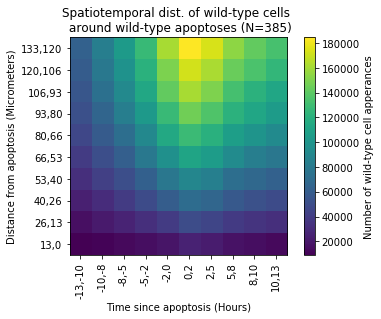

In [19]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around wild-type apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type cell apperances', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/wt_apop_wt_div/Spatiotemporal dist. of wild-type mitoses 
 around wild-type apoptoses (N=385).pdf


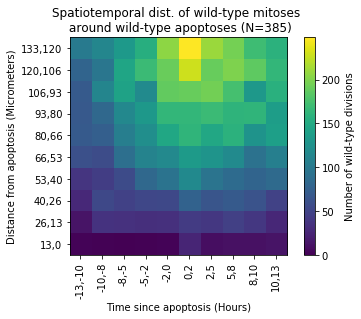

In [20]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type mitoses \n around wild-type apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/wt_apop_wt_div/Spatiotemporal dist. of probability of wild-type division 
 around wild-type apoptoses (N=385).pdf


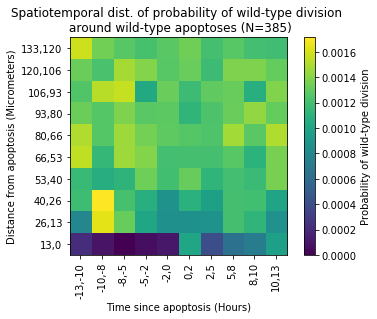

In [21]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around wild-type apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Probability of wild-type division', 
                save_path = save_path,#'/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/400.400.10/scr_apop_wt_div',
                SI = True)

# 5) Miscellaneous section: segregating cumulative plots based on experiment type

50:50 expt

In [27]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/individual_spatiotemporal_heatmaps/400.400.10/scr_apop_wt_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types'
Path(save_path).mkdir(parents=True, exist_ok=True)

In [28]:
expt_list_5050 = ['GV0794/Pos4',
                 'GV0794/Pos7',
                 'GV0794/Pos16',
                 'GV0795/Pos4',
                 'GV0795/Pos7',
                 'GV0795/Pos17',
                 'GV0796/Pos4',
                 'GV0796/Pos7',
                 'GV0796/Pos21',
                 'GV0796/Pos22',
                 'GV0797/Pos4',
                 'GV0797/Pos7',
                 'GV0797/Pos20',
                 'GV0797/Pos21',
                 'GV0798/Pos4',
                 'GV0798/Pos7',
                 'GV0798/Pos20',
                 'GV0798/Pos21',
                 'GV0800/Pos4', 
                 'GV0800/Pos7',
                 'GV0800/Pos16',
                 'GV0801/Pos4',
                 'GV0802/Pos4',
                 'GV0804/Pos4',
                 'GV0805/Pos4',
                 'GV0806/Pos4',
                 'GV0807/Pos4',
                 'GV0812/Pos0',
                 'GV0812/Pos1',
                 'GV0812/Pos2',
                 'GV0812/Pos3',
                 'GV0812/Pos4',
                 'GV0812/Pos5',
                 'GV0813/Pos0',
                 'GV0813/Pos1',
                 'GV0813/Pos2',
                 'GV0813/Pos3',
                 'GV0813/Pos4',
                 'GV0813/Pos5',
                 'GV0814/Pos0',
                 'GV0814/Pos11',
                 'GV0814/Pos12',
                 'GV0814/Pos23',
                 'GV0815/Pos0',
                 'GV0815/Pos11',
                 'GV0815/Pos12',
                 'GV0815/Pos23',
                 'GV0816/Pos0',
                 'GV0816/Pos13',
                 'GV0816/Pos14',
                 'GV0816/Pos23',
                 'GV0817/Pos0',
                 'GV0817/Pos11',
                 'GV0817/Pos12',
                 'GV0817/Pos23',
                 'GV0818/Pos12',
                 'GV0818/Pos13',
                 'GV0819/Pos0',
                 'GV0819/Pos1',
                 'GV0819/Pos2',
                 'GV0819/Pos3',
                 'GV0819/Pos4',
                 'GV0819/Pos5',
                 'GV0820/Pos0',
                 'GV0820/Pos1',
                 'GV0820/Pos2',
                 'GV0820/Pos3',
                 'GV0820/Pos4',
                 'GV0820/Pos5']

In [37]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_5050:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

1111

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells 
 around Scribble apoptoses (N=1111, 50:50 wt:scr expts only).pdf


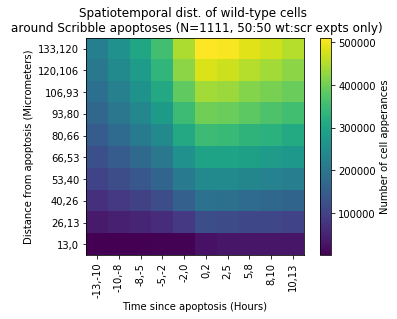

In [38]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division 
 around Scribble apoptoses (N=1111, 50:50 wt:scr expts only).pdf


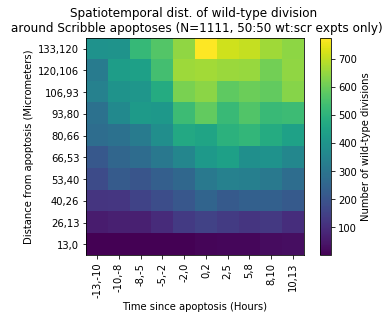

In [39]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of Scribble division 
 around wild-type apoptoses (N=1111, 50:50 wt:scr expts only).pdf


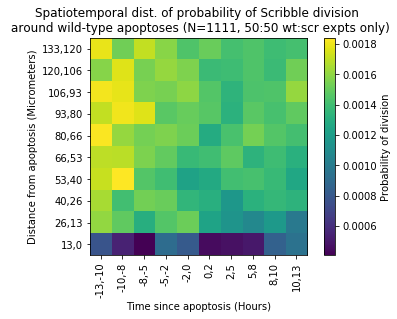

In [40]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of probability of Scribble division \n around wild-type apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

90:10 wt:scr

In [41]:
expt_list_9010 = ['GV0794/Pos3',
 'GV0794/Pos8',
 'GV0794/Pos15',
 'GV0795/Pos3',
 'GV0795/Pos8',
 'GV0795/Pos16',
 'GV0796/Pos3',
 'GV0796/Pos8',
 'GV0796/Pos19',
 'GV0796/Pos20',
 'GV0797/Pos3',
 'GV0797/Pos8',
 'GV0797/Pos18',
 'GV0797/Pos19',
 'GV0798/Pos3',
 'GV0798/Pos8',
 'GV0798/Pos18',
 'GV0798/Pos19',
 'GV0800/Pos3',
 'GV0800/Pos8',
 'GV0800/Pos15',
 'GV0801/Pos3',
 'GV0802/Pos3',
 'GV0804/Pos3',
 'GV0805/Pos3',
 'GV0806/Pos3',
 'GV0807/Pos3']

In [42]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_9010:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

131

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


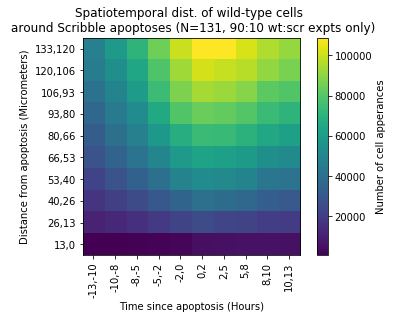

In [43]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


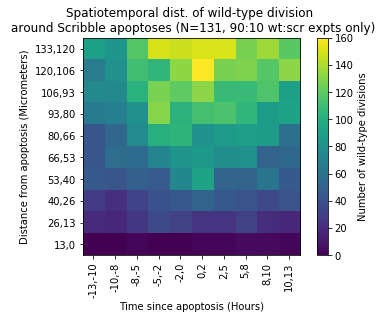

In [44]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of wild-type division 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


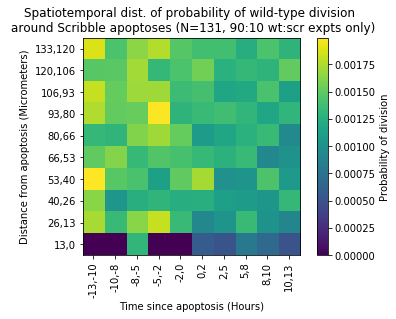

In [45]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

10:90 wt:scr

In [46]:
expt_list_1090 = ['GV0794/Pos5',
 'GV0794/Pos6',
 'GV0795/Pos5',
 'GV0795/Pos6',
 'GV0795/Pos18',
 'GV0796/Pos5',
 'GV0796/Pos6',
 'GV0796/Pos23',
 'GV0796/Pos24',
 'GV0797/Pos5',
 'GV0797/Pos6',
 'GV0797/Pos22',
 'GV0797/Pos23',
 'GV0798/Pos5',
 'GV0798/Pos6',
 'GV0798/Pos22',
 'GV0798/Pos23',
 'GV0800/Pos5',
 'GV0800/Pos6',
 'GV0800/Pos17',
 'GV0801/Pos5',
 'GV0802/Pos5',
 'GV0804/Pos5',
 'GV0805/Pos5',
 'GV0806/Pos5',
 'GV0807/Pos5']

In [47]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_1090:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

597

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


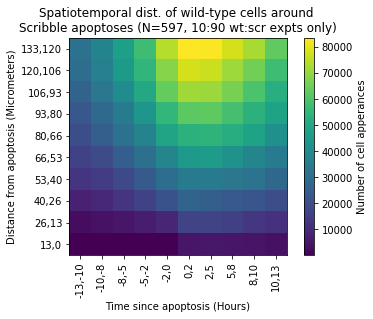

In [48]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of wild-type cells around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


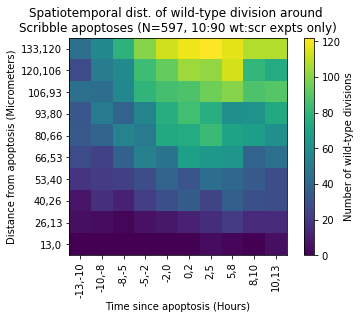

In [49]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 10,
                radius  = 400,
                t_range = 400,  
                title = 'Spatiotemporal dist. of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of wild-type division around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


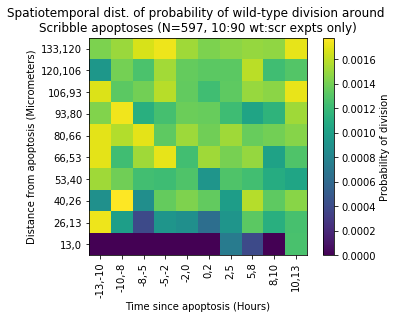

In [50]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 10,
                radius  = 400,
                t_range = 400, 
                title = 'Spatiotemporal dist. of probability of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/follow/cumulative_plots/400.400.10/scr_apop_wt_div/expt_types',
                SI = True)

Write a function to do a time evolving plot that iteratively adds single cell heat maps according to the apoptosis time?